## Testing

In [392]:
import pandas as pd
import numpy as np
import plotly.express as px
from Model import RedemptionModel 
from Salesmodel import SalesModel 

In [393]:
!pip install xgboost

## Redemption Model

In [380]:
def load_data(file):
    # generic data processing function
    df = pd.read_csv(file,
                dtype={'_id':int, 'Redemption Count': int, 'Sales Count':int},
                parse_dates=['Timestamp'])
    df.sort_values('Timestamp', inplace=True)
    # convert to time-aware
    df.set_index('Timestamp', inplace=True)
    df_daily = df.resample('d').sum()
    # engineer some time features 
    df_daily['monthly'] = df_daily.reset_index().Timestamp.dt.month.values
    df_daily['quarter'] = df_daily.reset_index().Timestamp.dt.quarter.values
    # Add lag features
    df_daily['lag_1'] = df_daily['Redemption Count'].shift(1)
    df_daily['lag_7'] = df_daily['Redemption Count'].shift(7)
    df_daily['lag_30'] = df_daily['Redemption Count'].shift(30)

    # Rolling features
    df_daily['roll_mean_7'] = df_daily['Redemption Count'].rolling(window=7).mean()
    df_daily['roll_std_7'] = df_daily['Redemption Count'].rolling(window=7).std()
    df_daily['roll_mean_30'] = df_daily['Redemption Count'].rolling(window=30).mean()
    df_daily['roll_std_30'] = df_daily['Redemption Count'].rolling(window=30).std()

    #add dayof the week
    df_daily['dayofweek'] = df_daily.index.dayofweek
    
    #remove rows with Nans caused by lags/rolling
    df_daily.dropna(inplace=True)
    return df, df_daily

In [310]:
df, df_daily=load_data('./data/Toronto Island Ferry Ticket Counts.csv')

In [343]:
df.head(10)

_id  Redemption Count  Sales Count
Timestamp                                                 
2015-05-01 13:30:00  246735                 0            1
2015-05-01 15:15:00  246734                 0            2
2015-05-01 15:45:00  246733                 0            1
2015-05-01 16:00:00  246732                 1            0
2015-05-04 16:00:00  246731                 0            2
2015-05-04 16:15:00  246730                 0            2
2015-05-04 16:30:00  246729                 0            3
2015-05-04 16:45:00  246728                 0            3
2015-05-04 17:00:00  246727                 4            6
2015-05-04 17:15:00  246726                 8           11

In [222]:
df_daily.head()

_id  Redemption Count  Sales Count  monthly  quarter   lag_1  \
Timestamp                                                                       
2015-05-31  12745642               406          609        5        2  3054.0   
2015-06-01  14703150              1116         1809        6        2   406.0   
2015-06-02  15679392              3025         3234        6        2  1116.0   
2015-06-03  16165083              2719         3977        6        2  3025.0   
2015-06-04  16650378              3432         3683        6        2  2719.0   

             lag_7  lag_30  roll_mean_7   roll_std_7  roll_mean_30  \
Timestamp                                                            
2015-05-31  8208.0     1.0  2274.142857  1251.256625   2588.966667   
2015-06-01  1221.0     0.0  2259.142857  1266.522066   2626.166667   
2015-06-02  2345.0     0.0  2356.285714  1299.844698   2727.000000   
2015-06-03  1898.0    12.0  2473.571429  1288.592366   2817.233333   
2015-06-04  2774.0   537.0  2567.571429  1337.242045   2913.733333   

            roll_std_30  dayofweek  
Timestamp                           
2015-05-31  2451.428640          6  
2015-06-01  2419.040392          0  
2015-06-02  2368.312596          1  
2015-06-03  2312.207554          2  
2015-06-04  2273.853753          3

Here we can see they have not concern about the interpolation to handle the missing values in time series data. Filling missing values by zeros won't help. It's better to use interpolation.

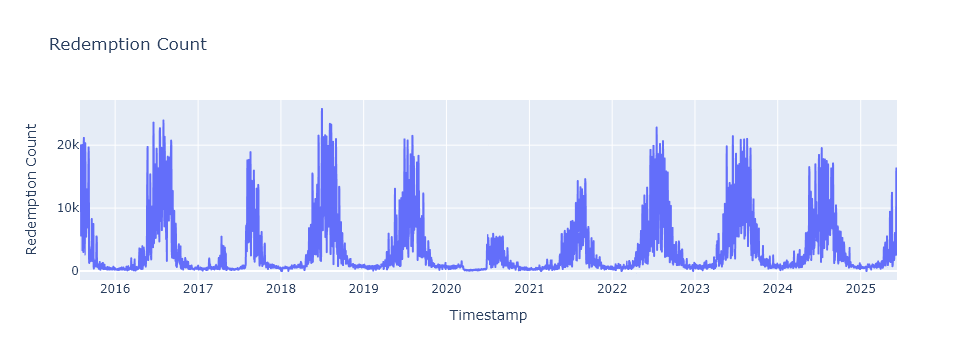

In [249]:
px.line(df_daily, x=df_daily.index, y="Redemption Count", title='Redemption Count')

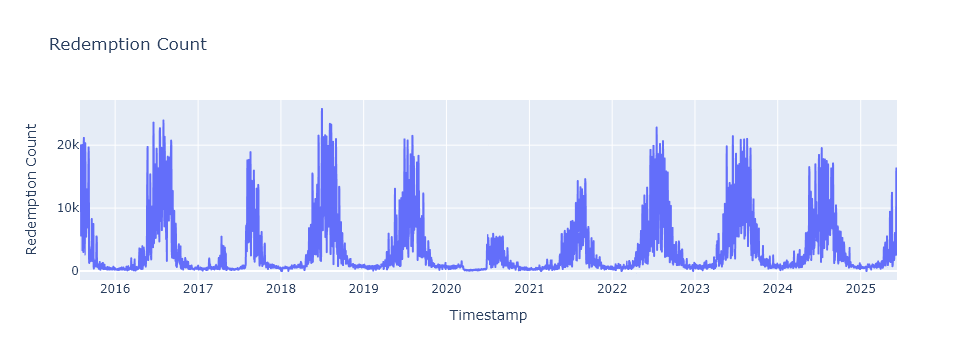

In [375]:
px.line(df_daily, x=df_daily.index, y="Redemption Count", title='Redemption Count')

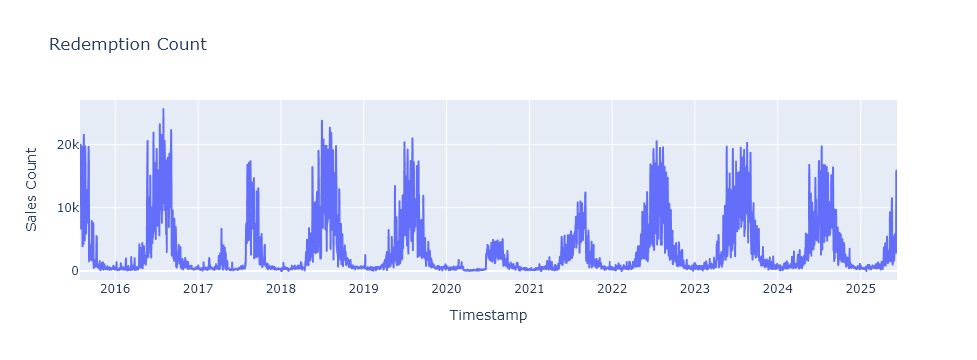

In [374]:
px.line(df_daily, x=df_daily.index, y="Sales Count", title='Redemption Count')

'sales count' time series and the 'redemption time' series shows almost similar patterns

### Run models

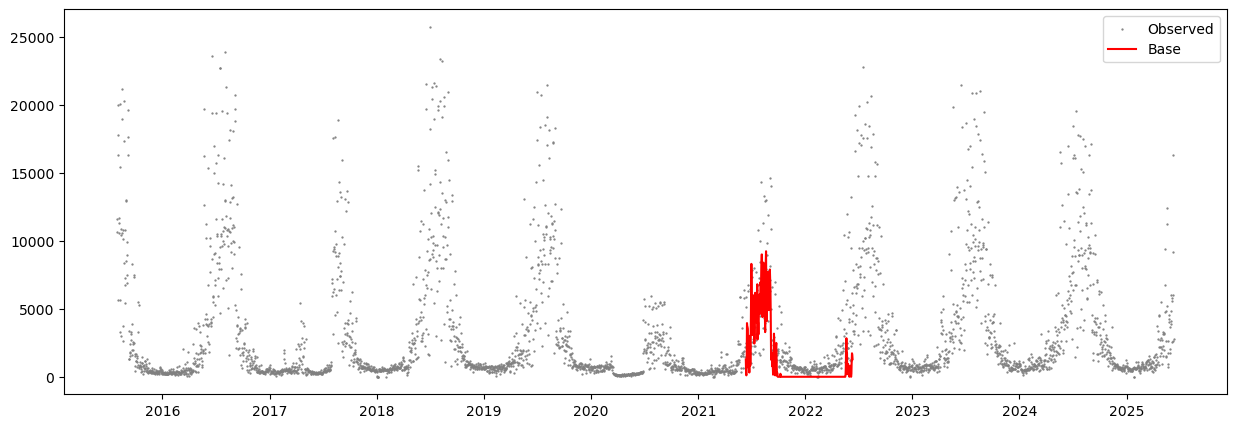

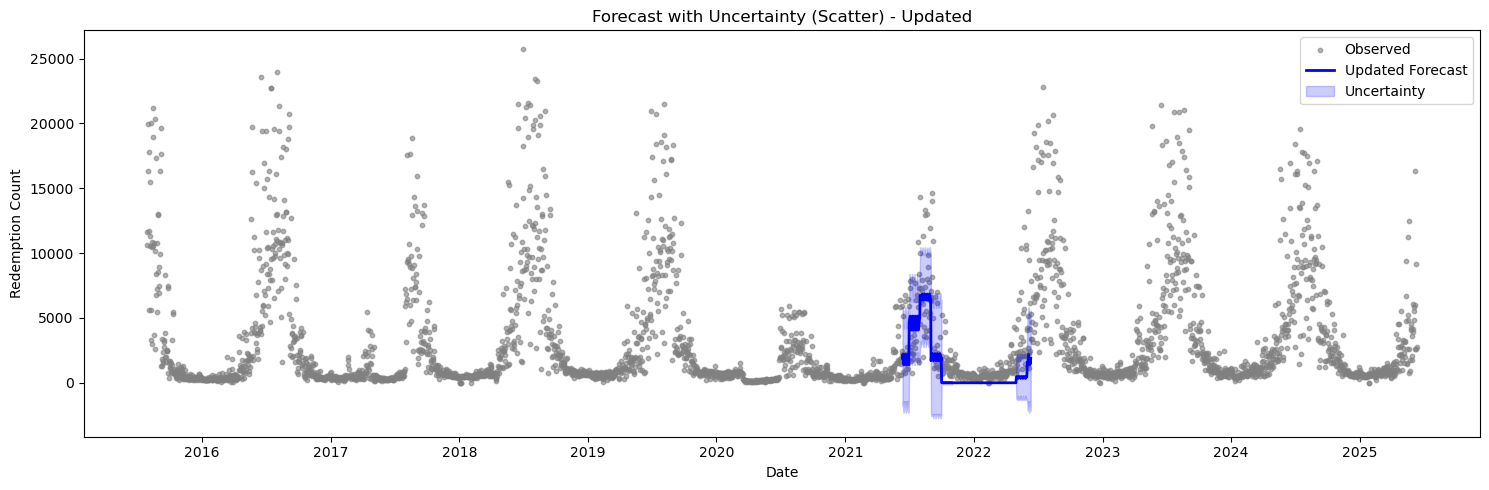

         Feature  Importance
0    Sales Count    0.972111
10     dayofweek    0.006876
9    roll_std_30    0.003351
7     roll_std_7    0.002977
3          lag_1    0.002967
6    roll_mean_7    0.002721
8   roll_mean_30    0.002712
4          lag_7    0.002224
5         lag_30    0.002164
1        monthly    0.001896
2        quarter    0.000000


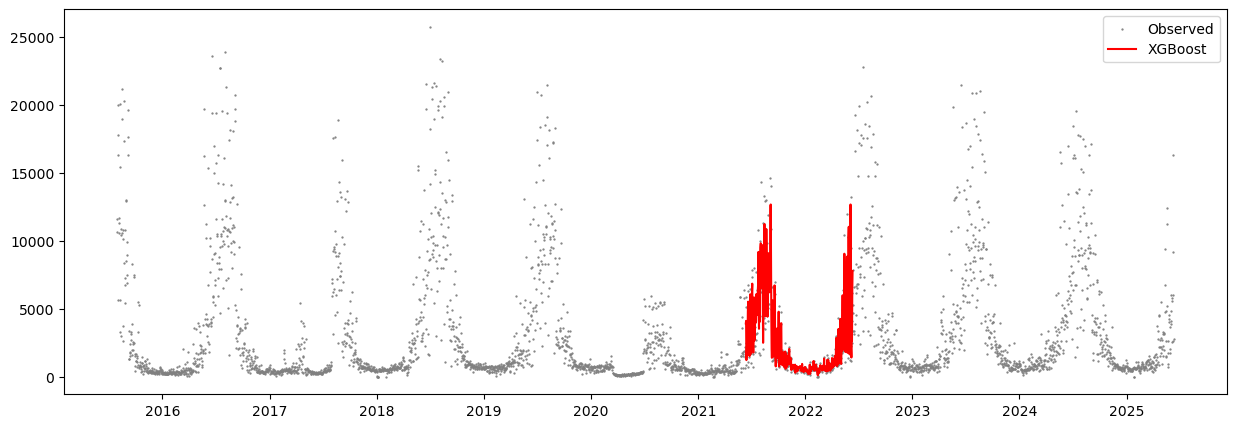

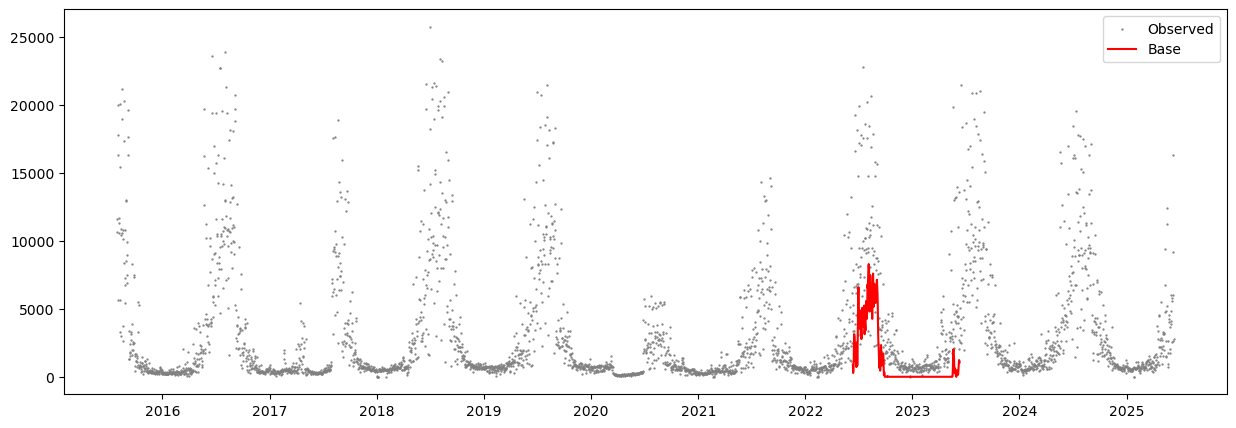

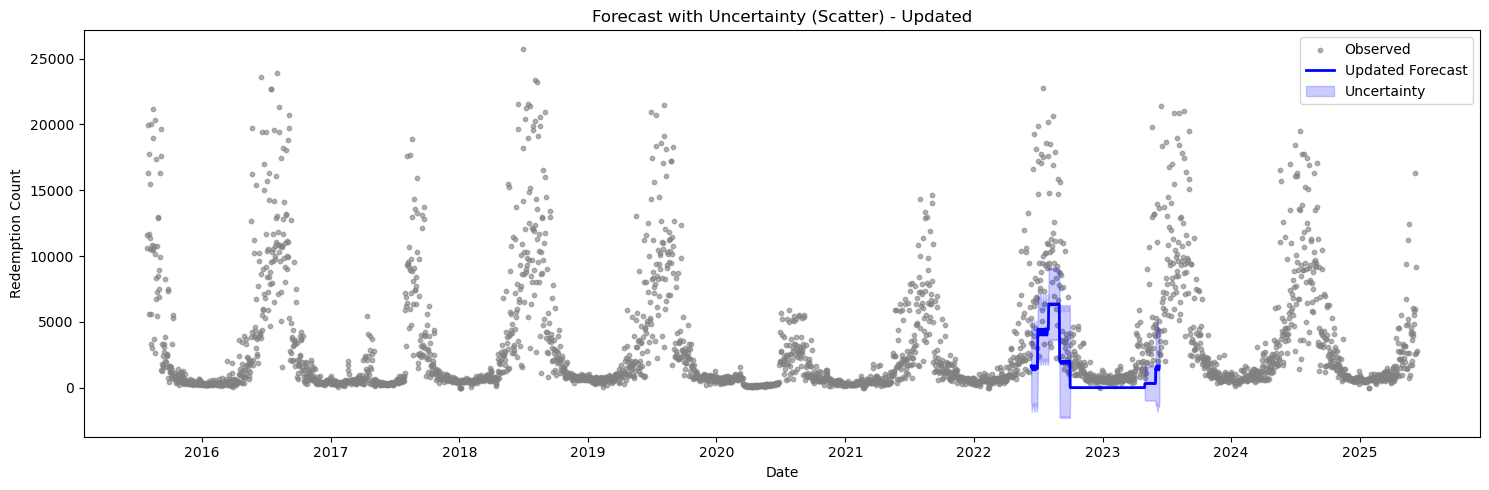

         Feature  Importance
0    Sales Count    0.965667
10     dayofweek    0.009846
9    roll_std_30    0.004068
7     roll_std_7    0.003716
8   roll_mean_30    0.003417
3          lag_1    0.003181
1        monthly    0.002755
6    roll_mean_7    0.002718
4          lag_7    0.002549
5         lag_30    0.002082
2        quarter    0.000000


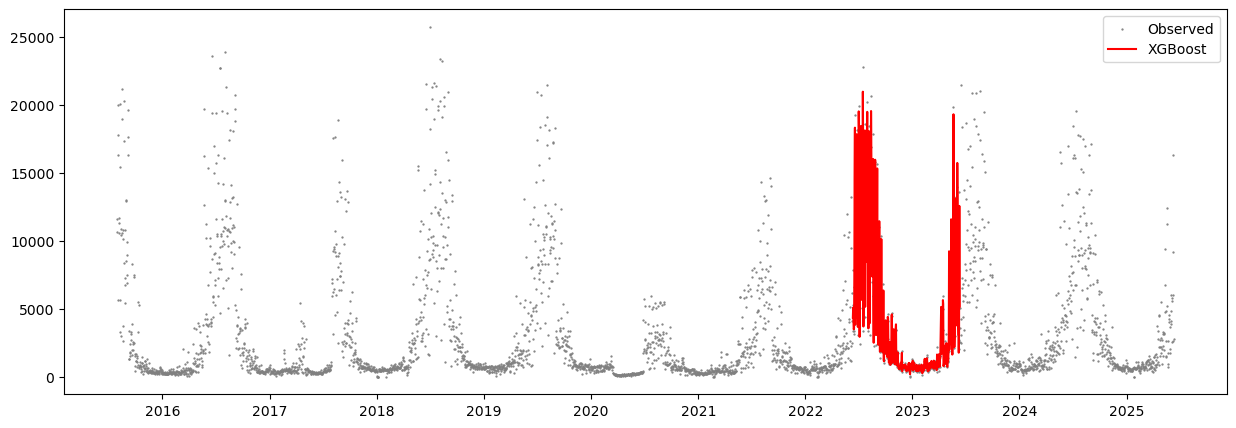

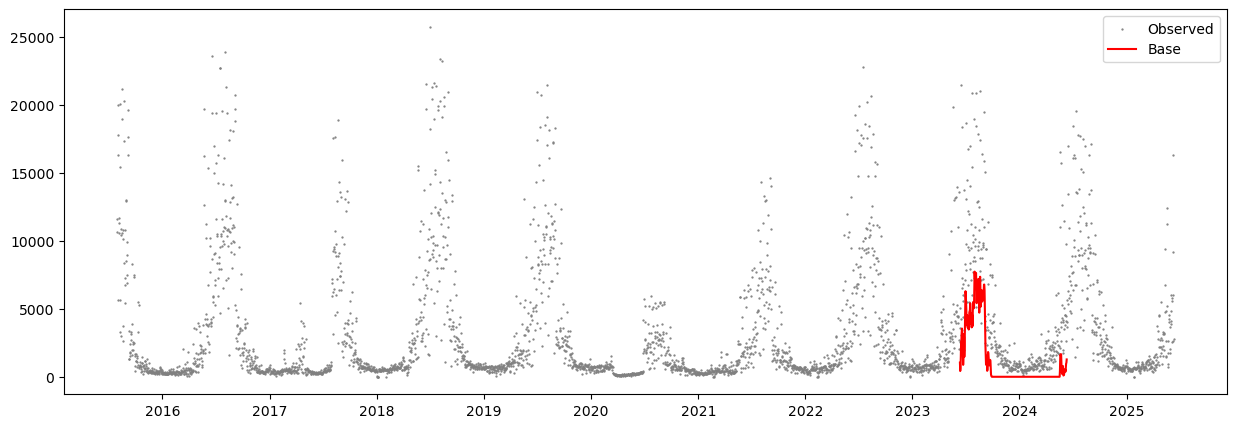

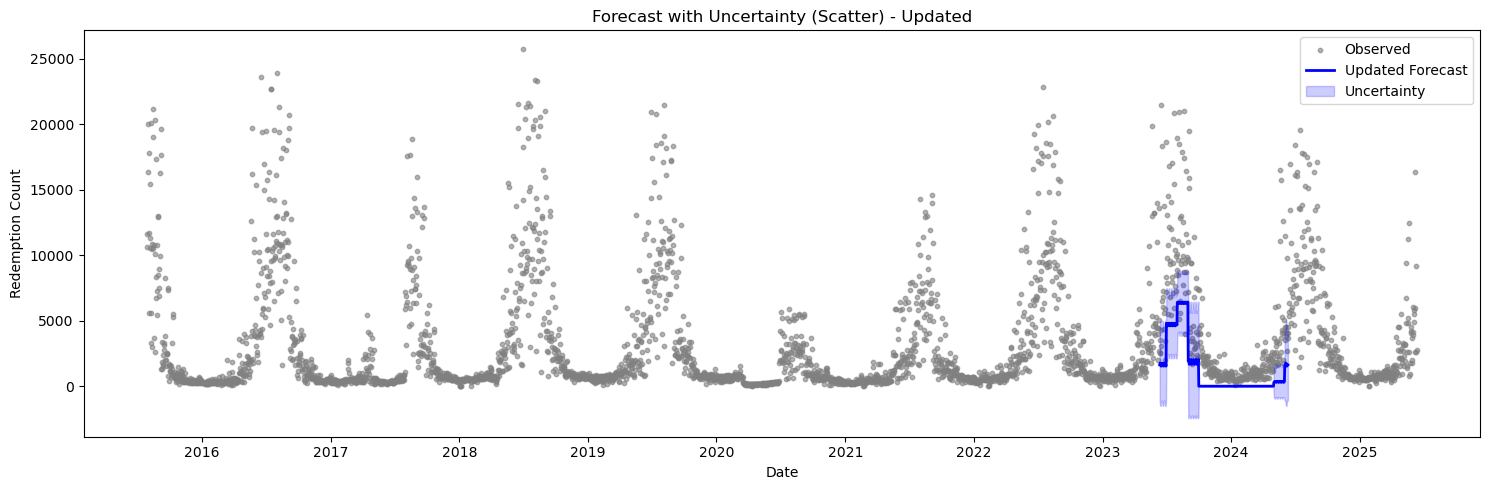

         Feature  Importance
0    Sales Count    0.968414
10     dayofweek    0.009590
7     roll_std_7    0.003591
9    roll_std_30    0.003431
3          lag_1    0.003108
1        monthly    0.002896
6    roll_mean_7    0.002411
8   roll_mean_30    0.002228
4          lag_7    0.002209
5         lag_30    0.002122
2        quarter    0.000000


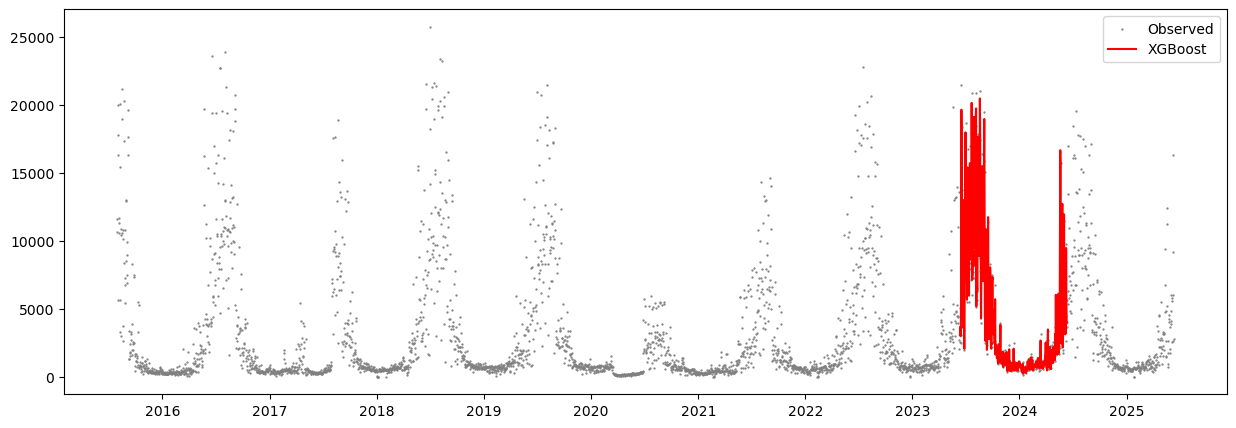

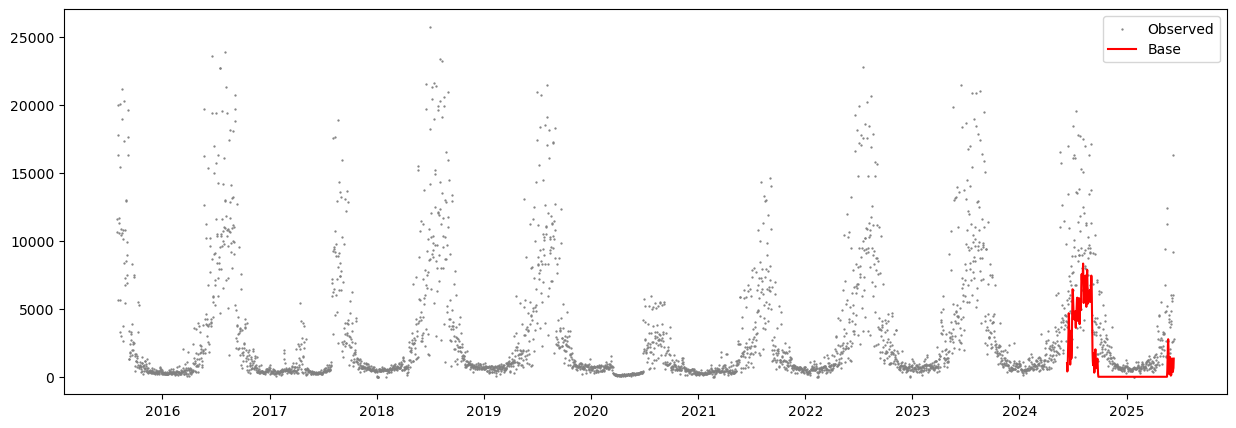

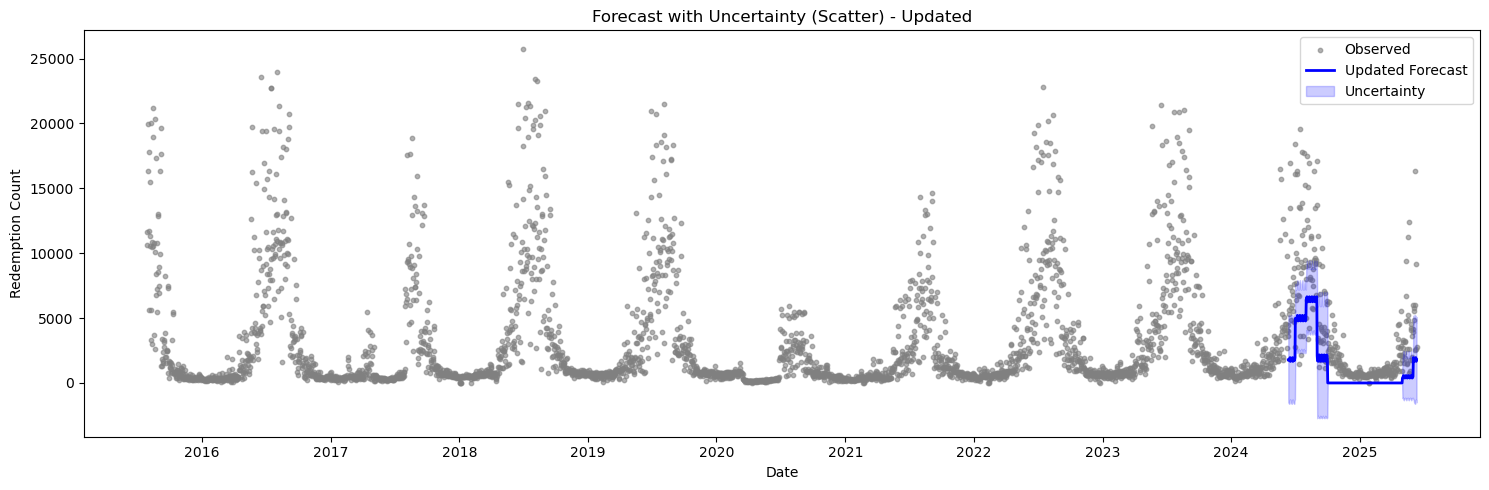

         Feature  Importance
0    Sales Count    0.971777
10     dayofweek    0.007629
9    roll_std_30    0.003218
7     roll_std_7    0.002970
3          lag_1    0.002895
1        monthly    0.002730
8   roll_mean_30    0.002314
4          lag_7    0.002210
5         lag_30    0.002132
6    roll_mean_7    0.002126
2        quarter    0.000000


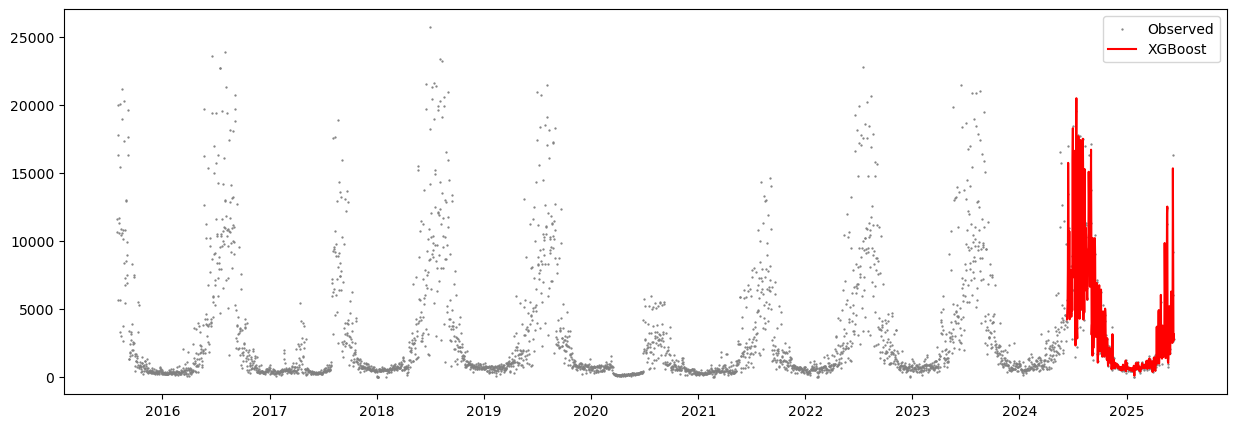

In [372]:
rm = RedemptionModel(df_daily, 'Redemption Count')
rm.run_models()

Through the feature importance we observed that sale count, day of the week, roll_mean_7, roll_std_7, monthly and lag 1 shows higher importance

In [373]:
# print model summary stats
rm.results

{'Base': {0: {'MAPE': 0.8957892427951479,
   'RMSE': 2667.1306491324467,
   'MSE': 7113585.899541666},
  1: {'MAPE': 0.8546219349548881,
   'RMSE': 4461.729302518966,
   'MSE': 19907028.368956376},
  2: {'MAPE': 0.849975398669082,
   'RMSE': 4212.634436578614,
   'MSE': 17746288.896248024},
  3: {'MAPE': 0.858758905881508,
   'RMSE': 3871.185055873244,
   'MSE': 14986073.73681633}},
 'Updated': {0: {'MAPE': 0.8184770927999999,
   'RMSE': 2545.2068142913286,
   'MSE': 6478077.727515014},
  1: {'MAPE': 0.8446143363509954,
   'RMSE': 4556.006632869009,
   'MSE': 20757196.438746404},
  2: {'MAPE': 0.830968652179756,
   'RMSE': 4366.943462831163,
   'MSE': 19070195.207563825},
  3: {'MAPE': 0.824783662311766,
   'RMSE': 3841.0412907368927,
   'MSE': 14753598.197145736}},
 'XGBoost': {0: {'MAPE': 3956148645904967.5,
   'RMSE': 745.2248867131159,
   'MSE': 555360.1317765764},
  1: {'MAPE': 2322780631887210.0,
   'RMSE': 417.42717604248776,
   'MSE': 174245.44729880604},
  2: {'MAPE': 0.083848

Based on the the MPAE, RMSE and MSE values updated model has a slight improvement of the time series forecasting.
But based on RMSE and MSE values XGBoost model shows a significantly better results. The above time series plots also shows that XGBOOst model could more accuratly identify the pattern. Also it's run time is very fast. For the evaluation of this model, MAPE is not recommended as the series has zero values. There are some days with no ticket sales.

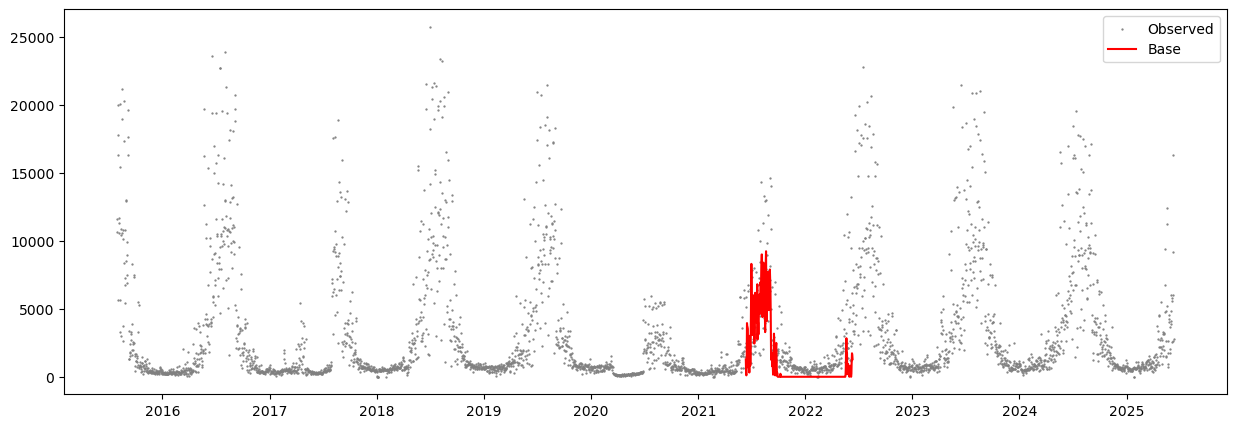

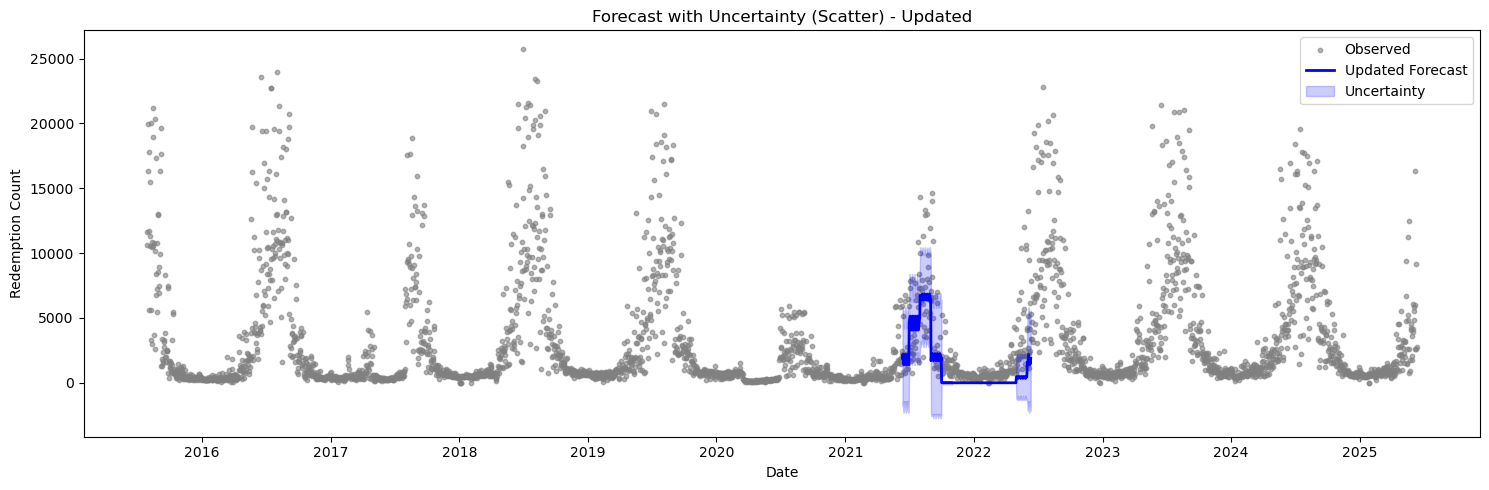

        Feature  Importance
5   roll_mean_7    0.652311
9     dayofweek    0.225262
6    roll_std_7    0.026738
0       monthly    0.023567
8   roll_std_30    0.019159
7  roll_mean_30    0.015283
3         lag_7    0.014182
2         lag_1    0.011877
4        lag_30    0.011620
1       quarter    0.000000


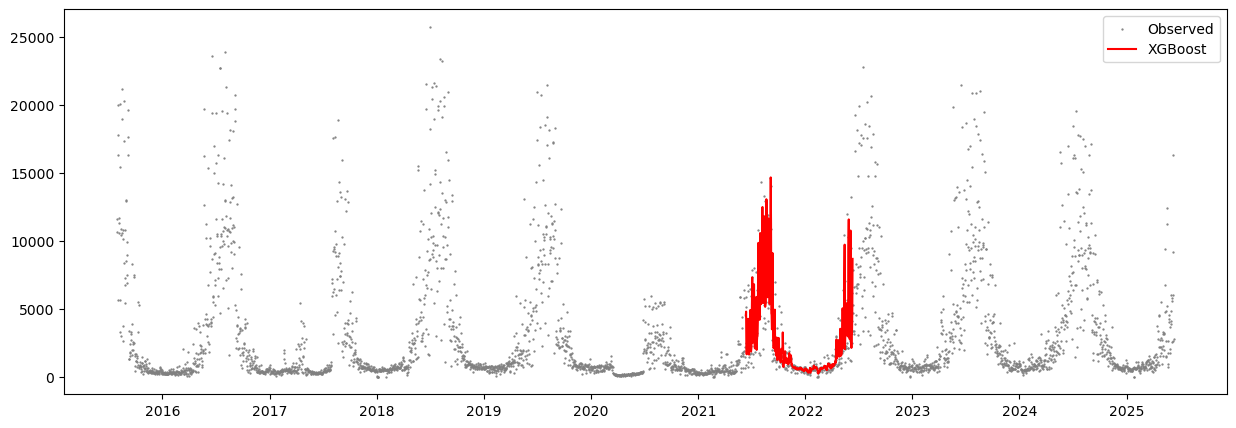

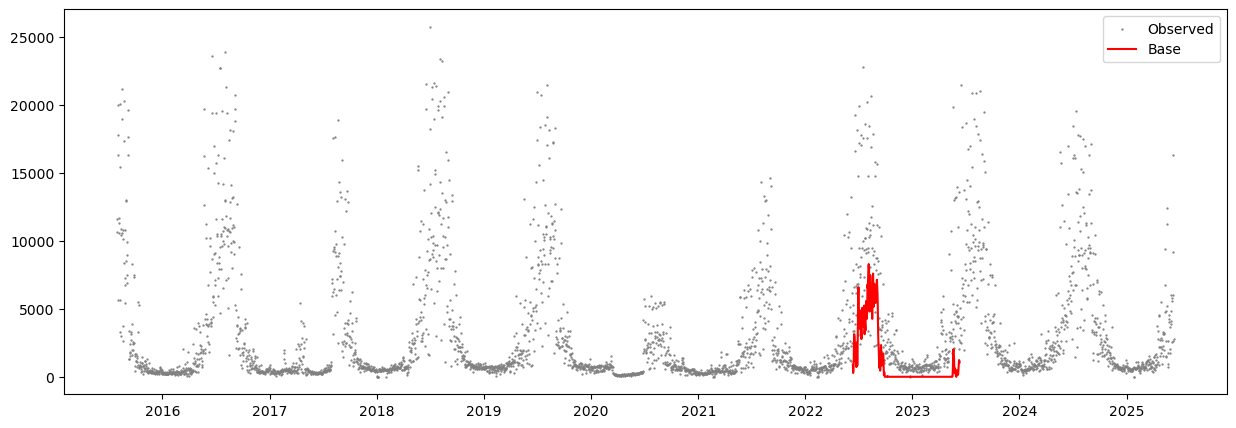

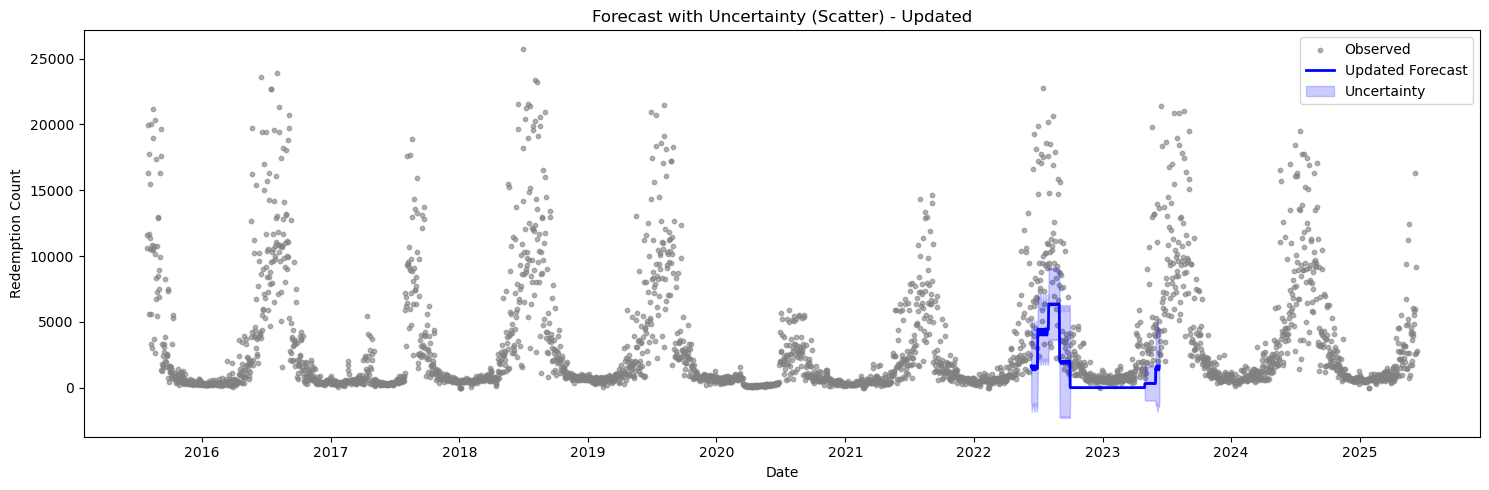

        Feature  Importance
5   roll_mean_7    0.634967
9     dayofweek    0.226234
6    roll_std_7    0.028751
0       monthly    0.028310
8   roll_std_30    0.019356
7  roll_mean_30    0.017778
2         lag_1    0.015288
3         lag_7    0.014972
4        lag_30    0.014344
1       quarter    0.000000


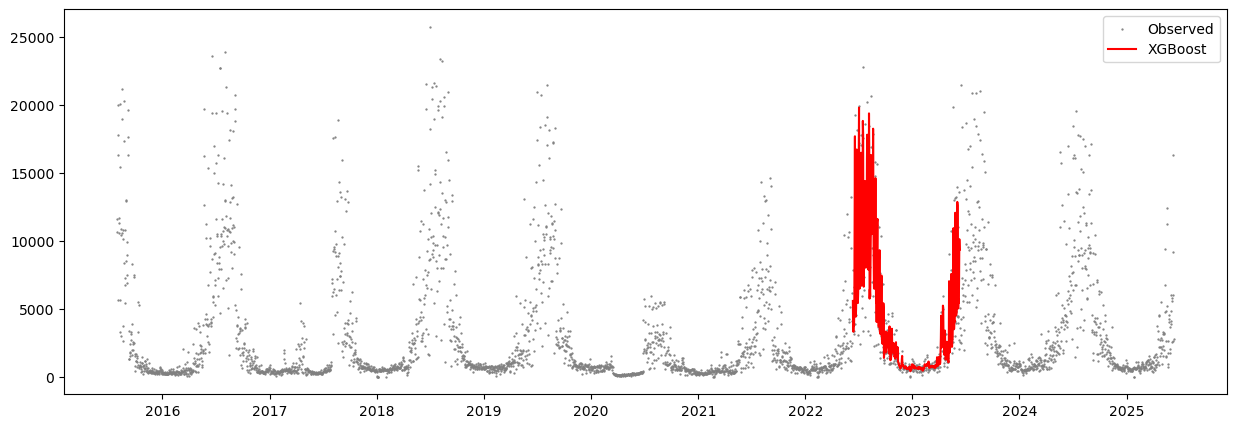

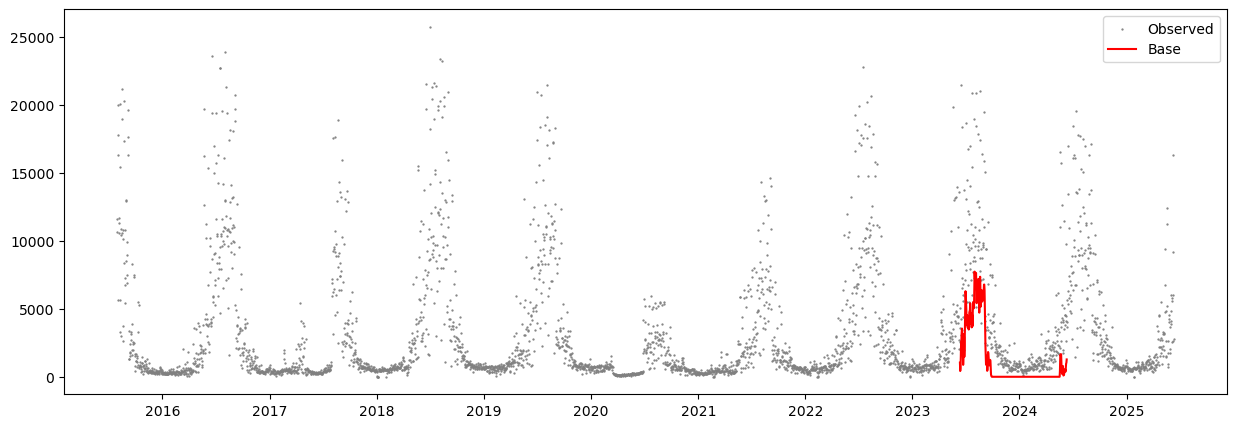

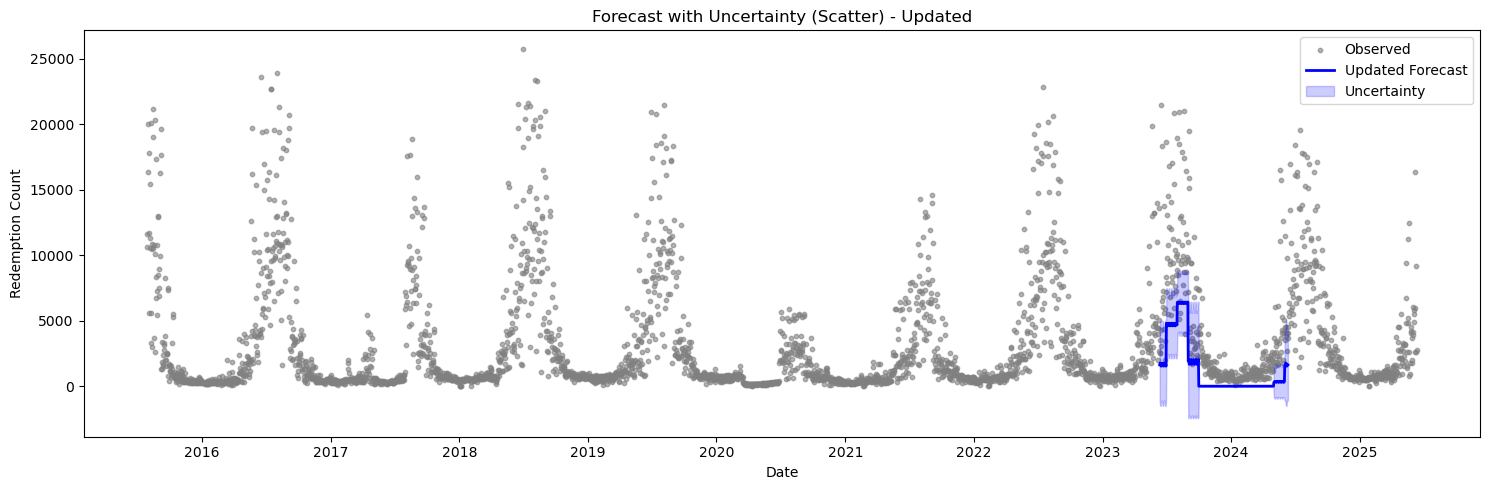

        Feature  Importance
5   roll_mean_7    0.623398
9     dayofweek    0.245621
6    roll_std_7    0.029933
0       monthly    0.020784
8   roll_std_30    0.019223
3         lag_7    0.017328
7  roll_mean_30    0.017147
2         lag_1    0.014253
4        lag_30    0.012312
1       quarter    0.000000


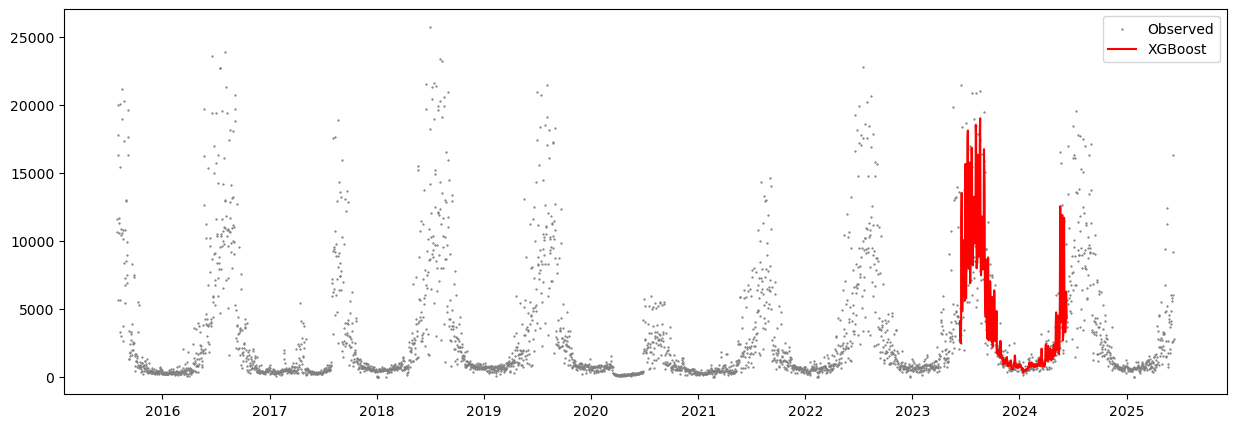

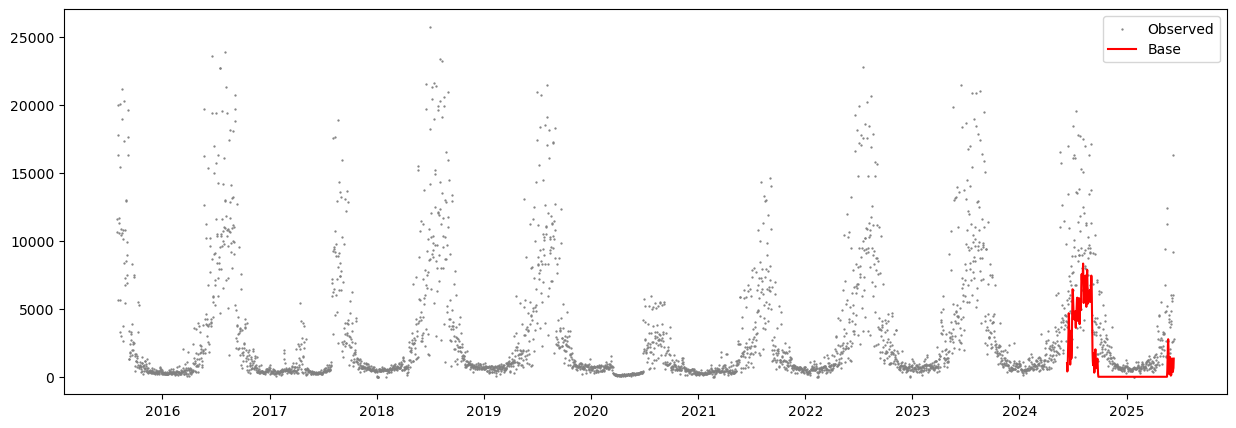

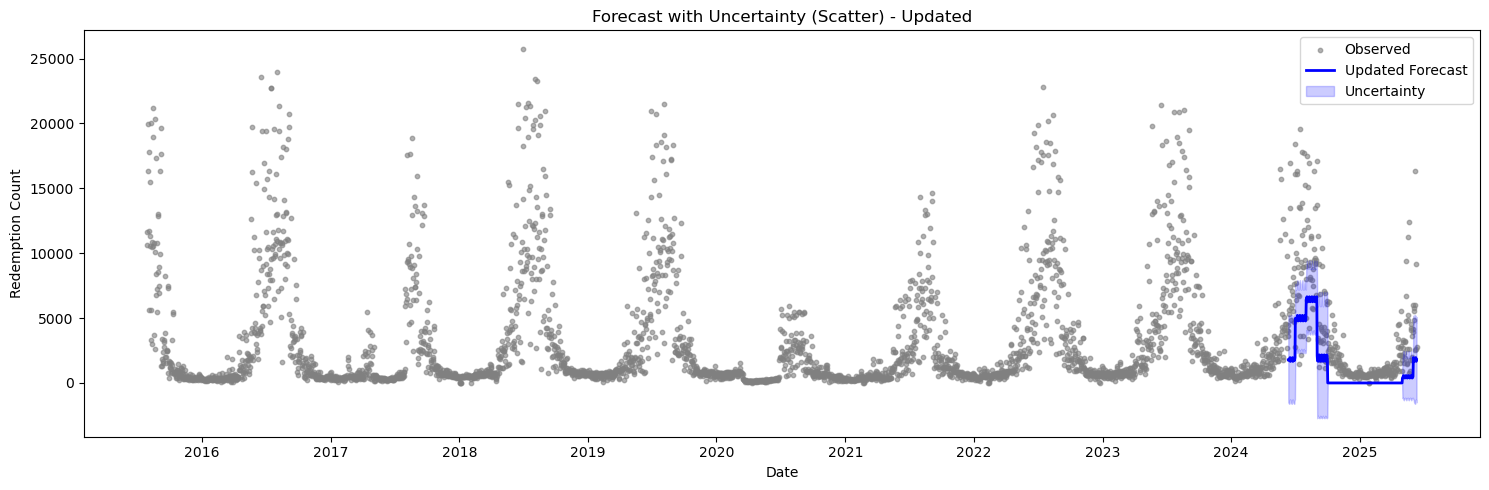

        Feature  Importance
5   roll_mean_7    0.618453
9     dayofweek    0.246170
0       monthly    0.026511
6    roll_std_7    0.026324
8   roll_std_30    0.021090
7  roll_mean_30    0.017117
3         lag_7    0.016590
2         lag_1    0.014315
4        lag_30    0.013430
1       quarter    0.000000


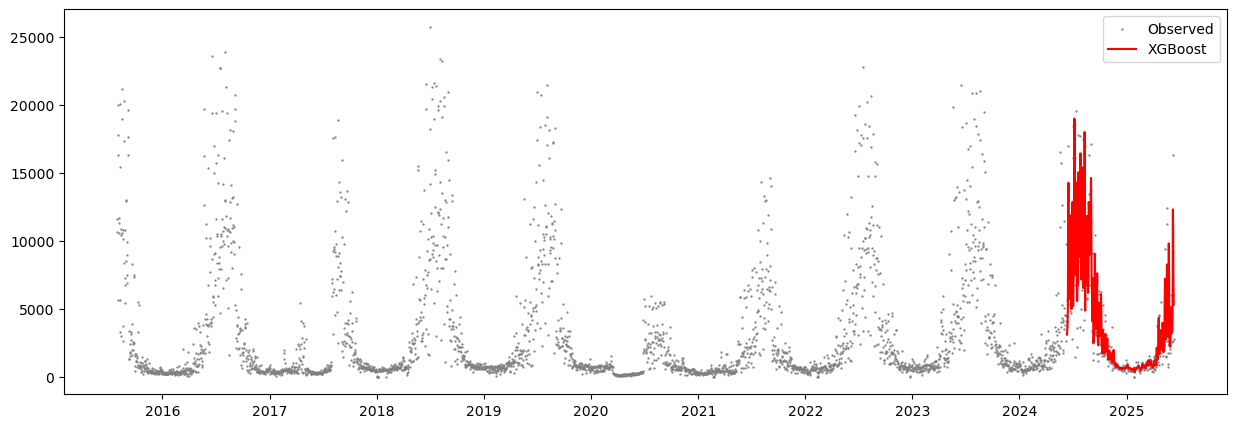

In [377]:
#if we remove sale count, then then prediction ability is lower
df_nosale = df_daily.drop(columns='Sales Count')
rm = RedemptionModel(df_nosale, 'Redemption Count')
rm.run_models()


In [378]:
rm.results

{'Base': {0: {'MAPE': 0.8957892427951479,
   'RMSE': 2667.1306491324467,
   'MSE': 7113585.899541666},
  1: {'MAPE': 0.8546219349548881,
   'RMSE': 4461.729302518966,
   'MSE': 19907028.368956376},
  2: {'MAPE': 0.849975398669082,
   'RMSE': 4212.634436578614,
   'MSE': 17746288.896248024},
  3: {'MAPE': 0.858758905881508,
   'RMSE': 3871.185055873244,
   'MSE': 14986073.73681633}},
 'Updated': {0: {'MAPE': 0.8184770927999999,
   'RMSE': 2545.2068142913286,
   'MSE': 6478077.727515014},
  1: {'MAPE': 0.8446143363509954,
   'RMSE': 4556.006632869009,
   'MSE': 20757196.438746404},
  2: {'MAPE': 0.830968652179756,
   'RMSE': 4366.943462831163,
   'MSE': 19070195.207563825},
  3: {'MAPE': 0.824783662311766,
   'RMSE': 3841.0412907368927,
   'MSE': 14753598.197145736}},
 'XGBoost': {0: {'MAPE': 1.188844876534871e+16,
   'RMSE': 1330.1992017333469,
   'MSE': 1769429.9162920334},
  1: {'MAPE': 5802447441631193.0,
   'RMSE': 1759.4646950053052,
   'MSE': 3095716.0129701113},
  2: {'MAPE': 0.3

## Sales prediction

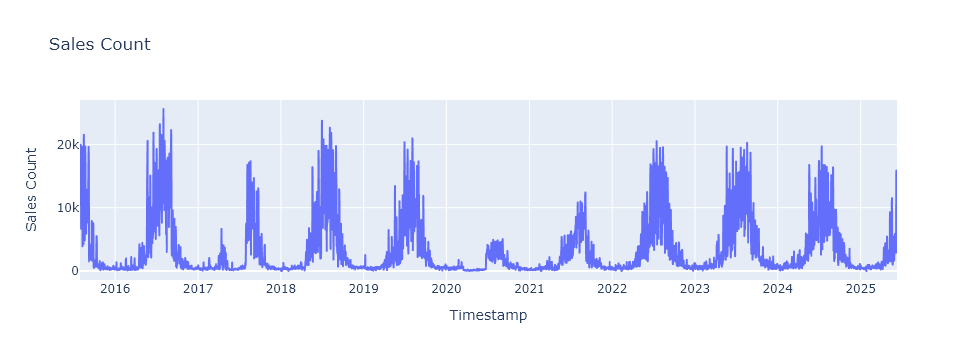

In [250]:
px.line(df_daily, x=df_daily.index, y="Sales Count", title='Sales Count')

this also shows similar seasonal patterns. So we can try above xgboost models in here also using RedemptionModel.

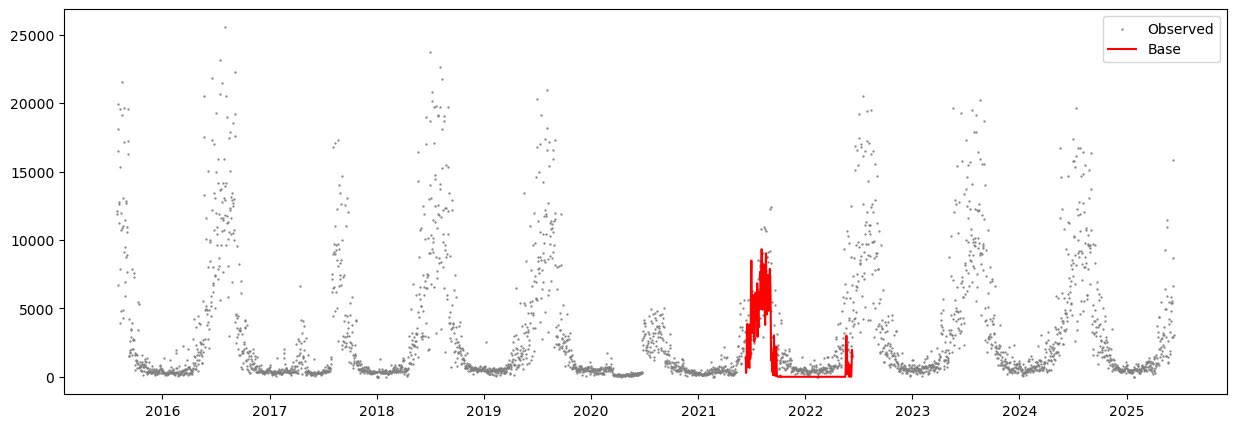

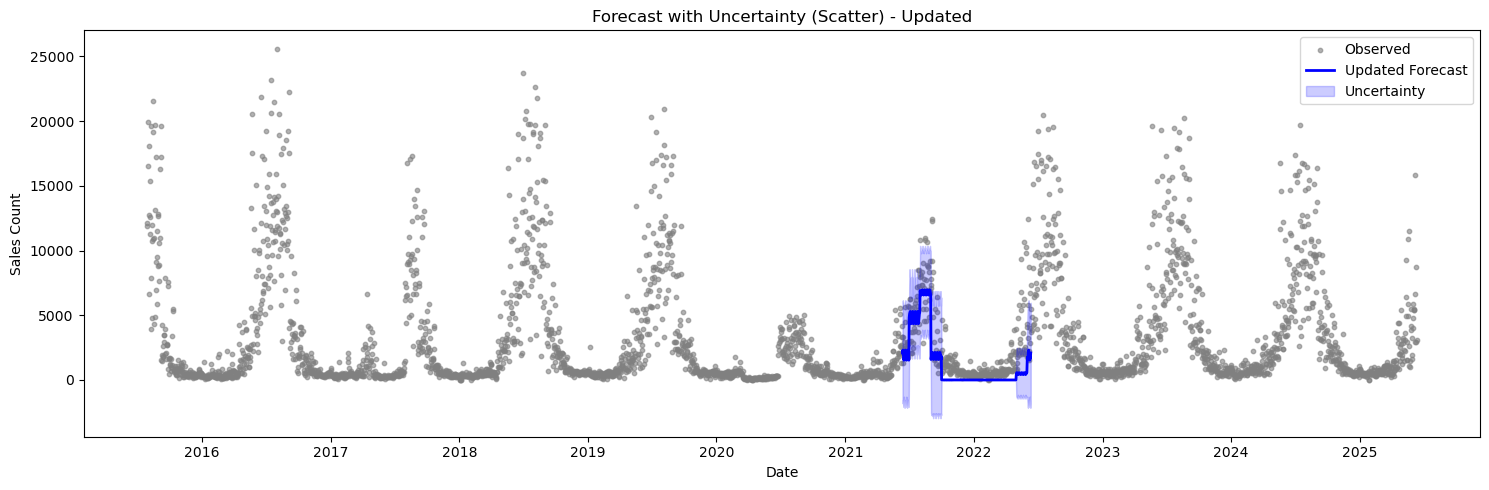

             Feature  Importance
0   Redemption Count    0.970557
6        roll_mean_7    0.005765
10         dayofweek    0.004216
1            monthly    0.003845
9        roll_std_30    0.003204
4              lag_7    0.002947
5             lag_30    0.002793
8       roll_mean_30    0.002380
7         roll_std_7    0.002192
3              lag_1    0.002101
2            quarter    0.000000


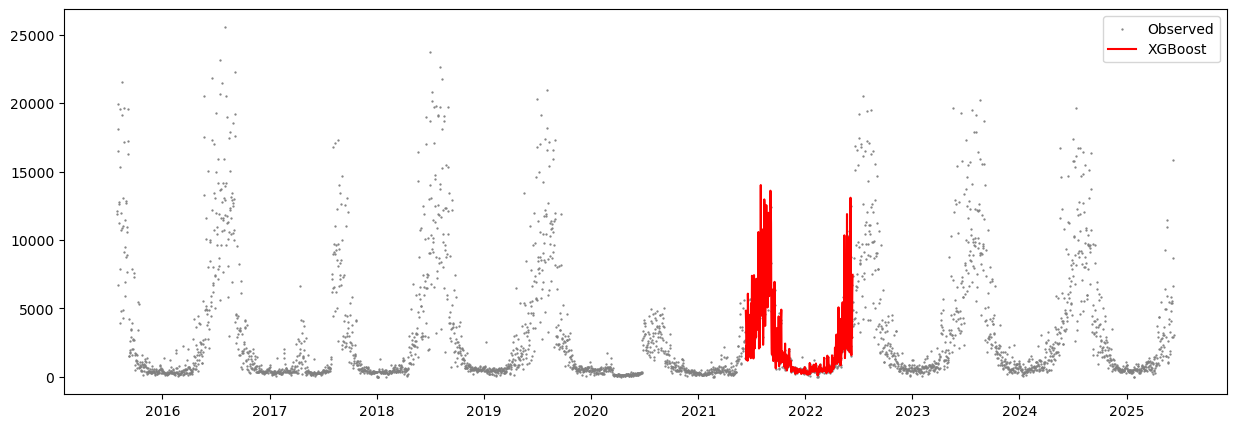

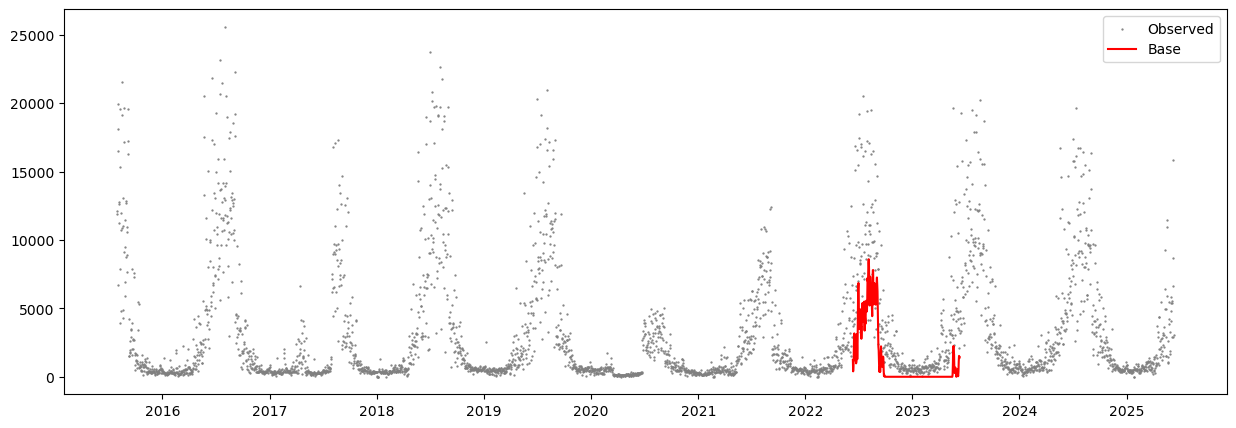

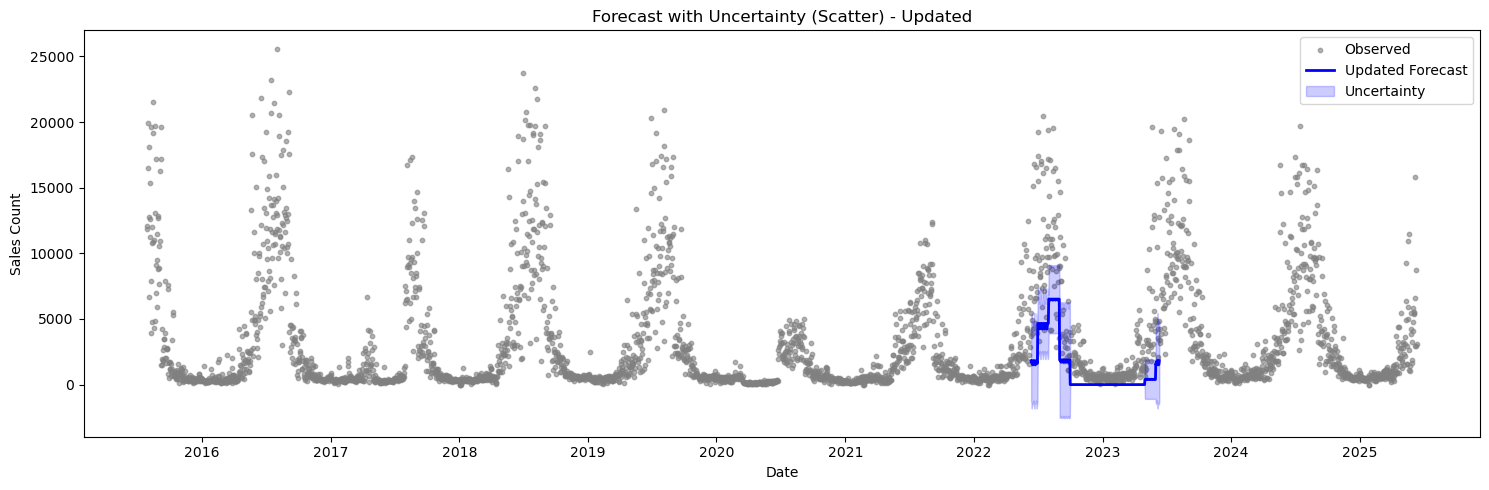

             Feature  Importance
0   Redemption Count    0.964777
6        roll_mean_7    0.008224
1            monthly    0.005276
9        roll_std_30    0.004209
10         dayofweek    0.003915
8       roll_mean_30    0.003459
5             lag_30    0.002739
4              lag_7    0.002707
7         roll_std_7    0.002434
3              lag_1    0.002259
2            quarter    0.000000


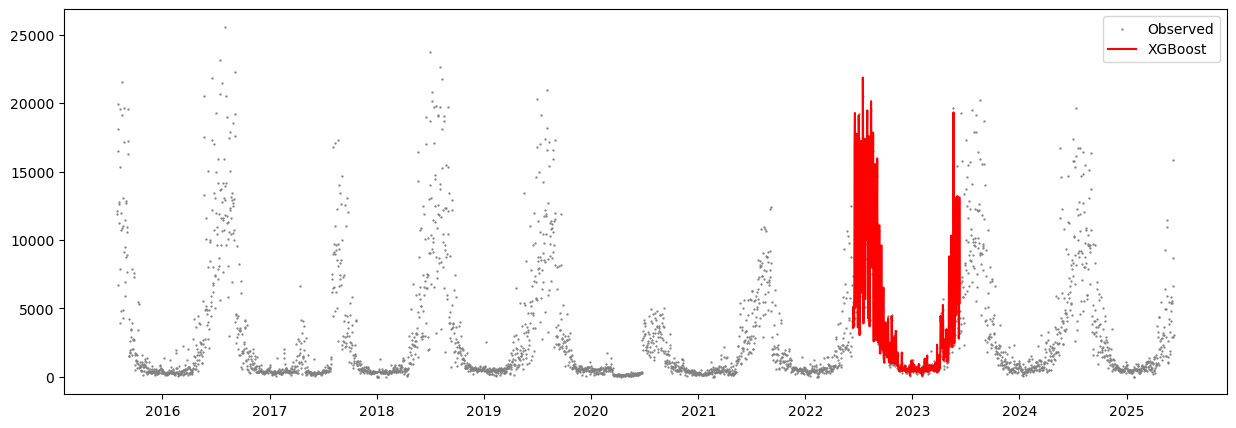

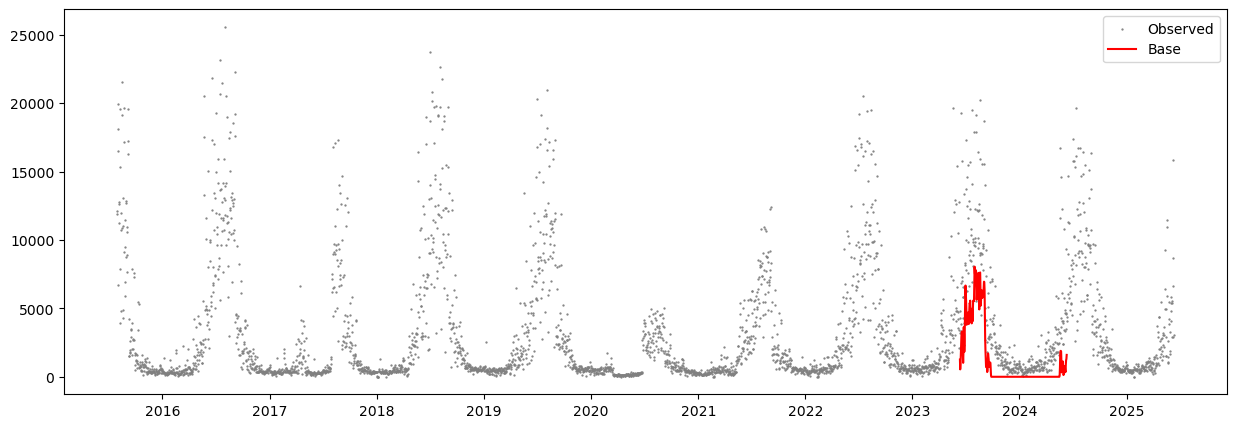

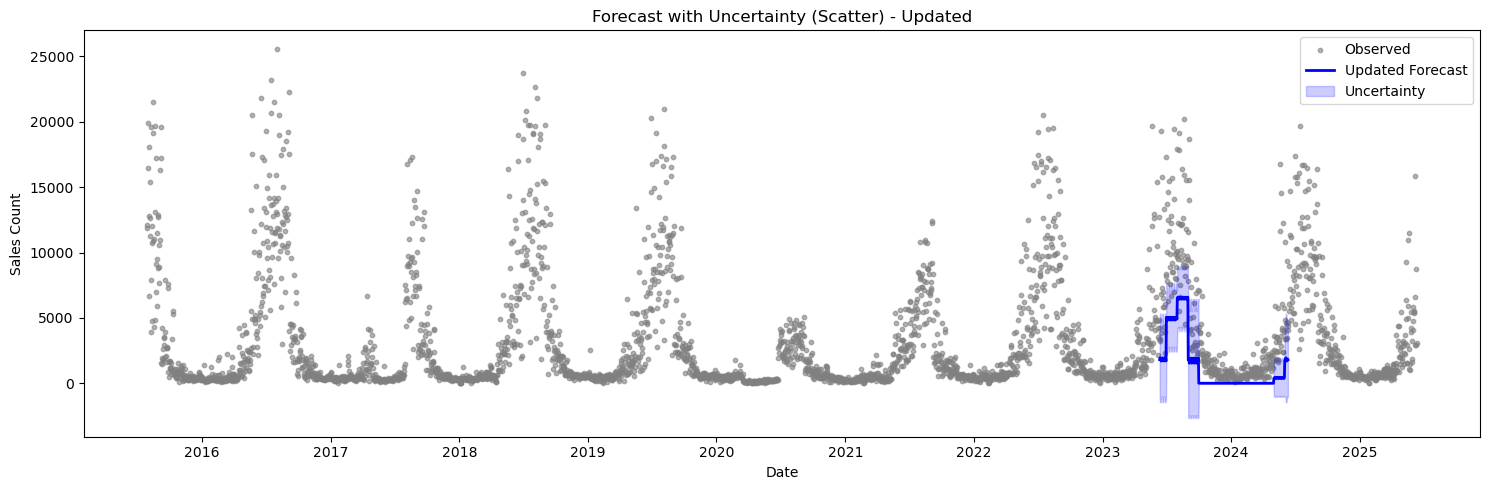

             Feature  Importance
0   Redemption Count    0.968788
6        roll_mean_7    0.006337
10         dayofweek    0.004921
1            monthly    0.004404
9        roll_std_30    0.004276
8       roll_mean_30    0.002471
7         roll_std_7    0.002312
5             lag_30    0.002211
3              lag_1    0.002148
4              lag_7    0.002133
2            quarter    0.000000


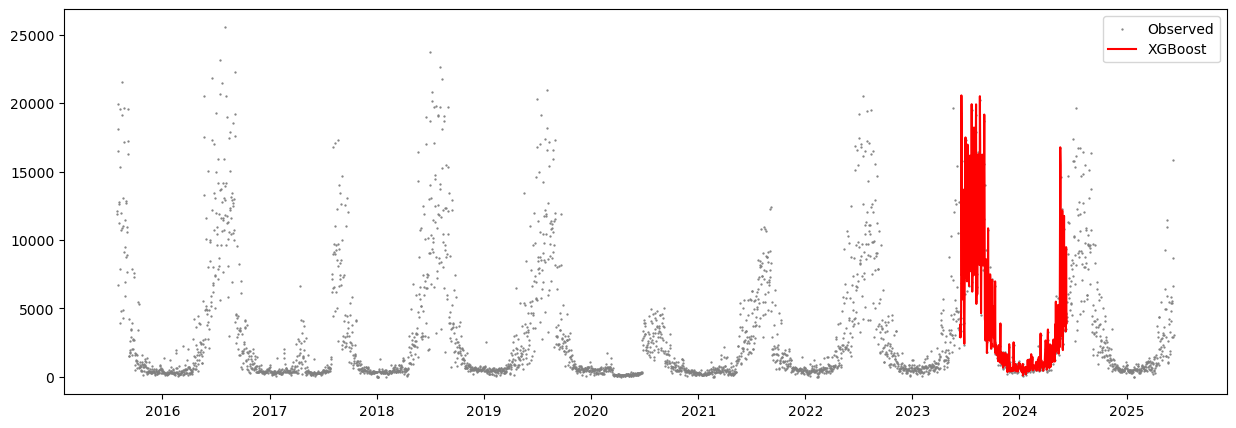

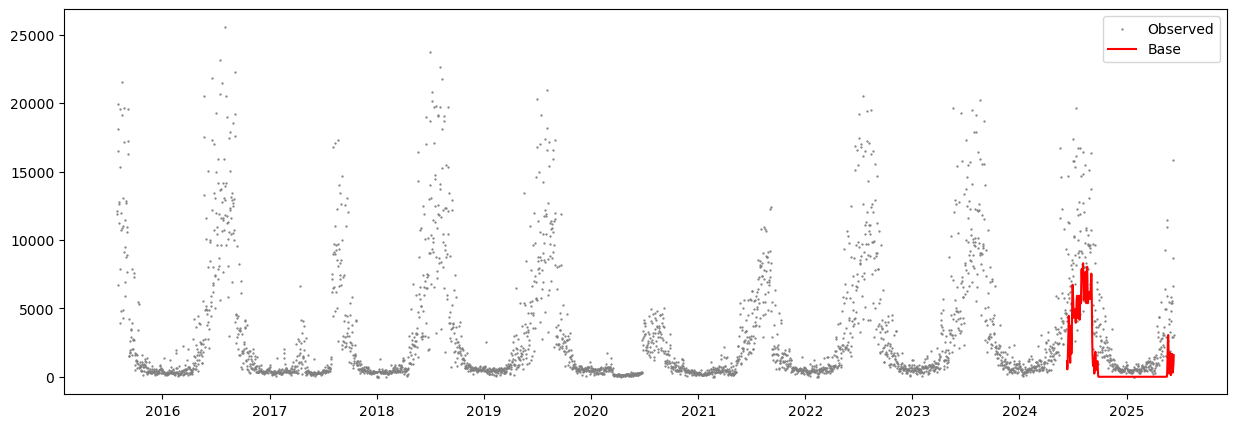

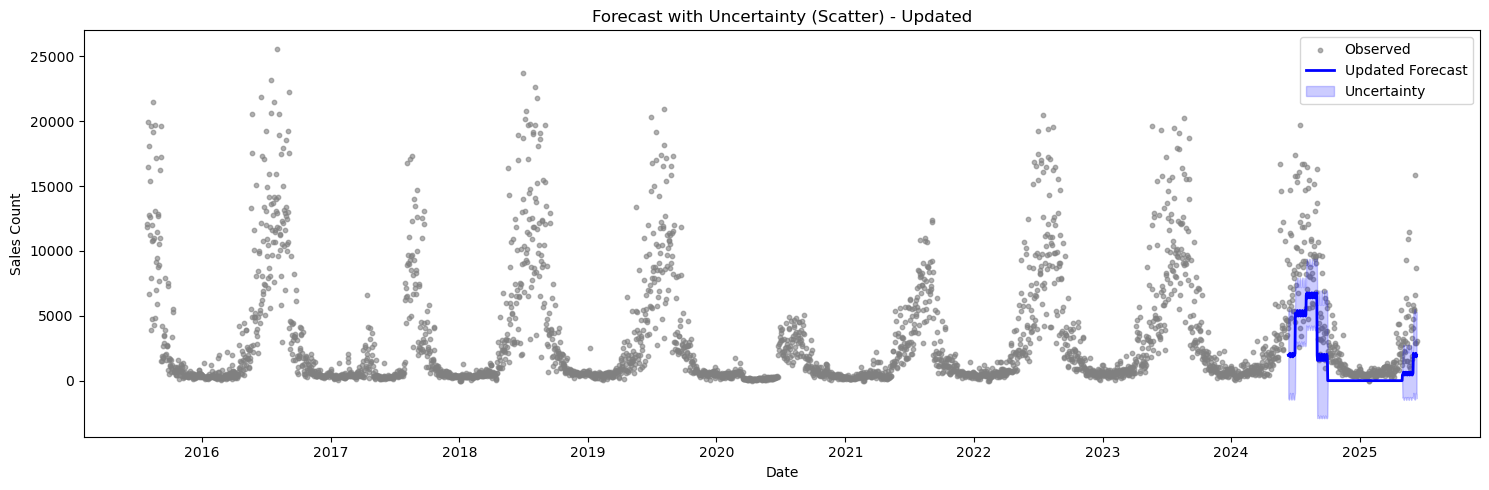

             Feature  Importance
0   Redemption Count    0.969473
6        roll_mean_7    0.005748
1            monthly    0.005199
10         dayofweek    0.004309
9        roll_std_30    0.003650
8       roll_mean_30    0.002943
7         roll_std_7    0.002418
4              lag_7    0.002202
5             lag_30    0.002173
3              lag_1    0.001886
2            quarter    0.000000


{'Base': {0: {'MAPE': 0.8213298088723193,
   'RMSE': 2255.095351927652,
   'MSE': 5085455.0462857},
  1: {'MAPE': 0.8543780110736318,
   'RMSE': 4248.820743635817,
   'MSE': 18052477.71155002},
  2: {'MAPE': 0.8501801175896795,
   'RMSE': 3954.3969140246113,
   'MSE': 15637254.953647368},
  3: {'MAPE': 0.8461201291380459,
   'RMSE': 3680.62642259868,
   'MSE': 13547010.862731557}},
 'Updated': {0: {'MAPE': 0.7665113565945219,
   'RMSE': 2216.533987660727,
   'MSE': 4913022.918455163},
  1: {'MAPE': 0.8363984145871398,
   'RMSE': 4365.657854203411,
   'MSE': 19058968.499967936},
  2: {'MAPE': 0.8307075383337085,
   'RMSE': 4128.303733739214,
   'MSE': 17042891.71800514},
  3: {'MAPE': 0.816778484565276,
   'RMSE': 3645.584763579167,
   'MSE': 13290288.26844057}},
 'XGBoost': {0: {'MAPE': 0.32934151543092577,
   'RMSE': 650.6355458240464,
   'MSE': 423326.6134897548},
  1: {'MAPE': 0.1156739131469131,
   'RMSE': 493.6331361008409,
   'MSE': 243673.6730567513},
  2: {'MAPE': 0.10697054260

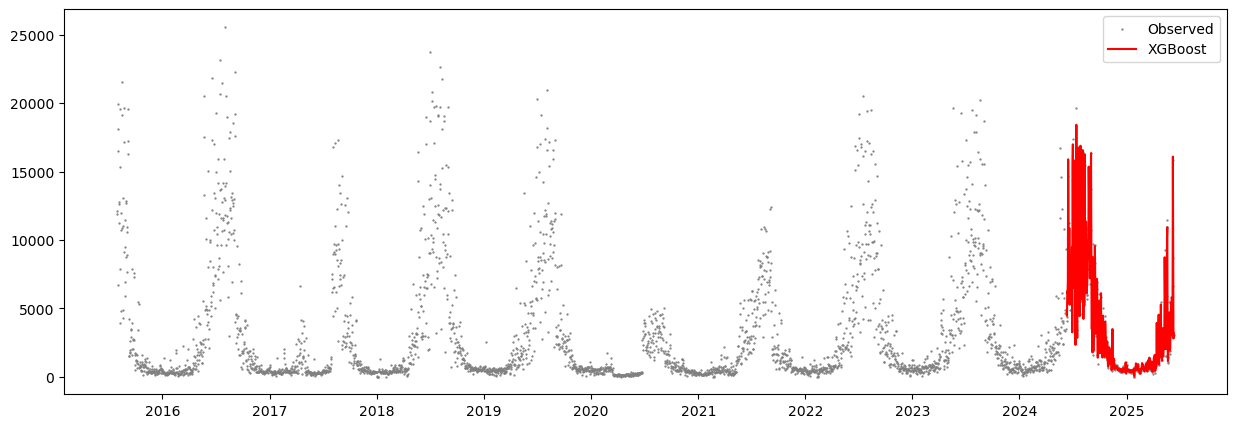

In [381]:
rm = RedemptionModel(df_daily, 'Sales Count')
rm.run_models()
rm.results

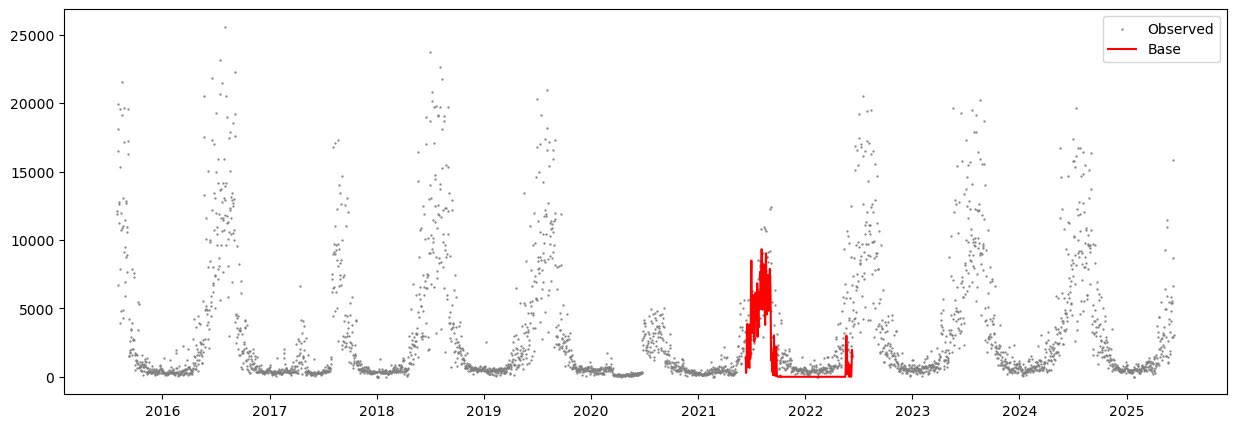

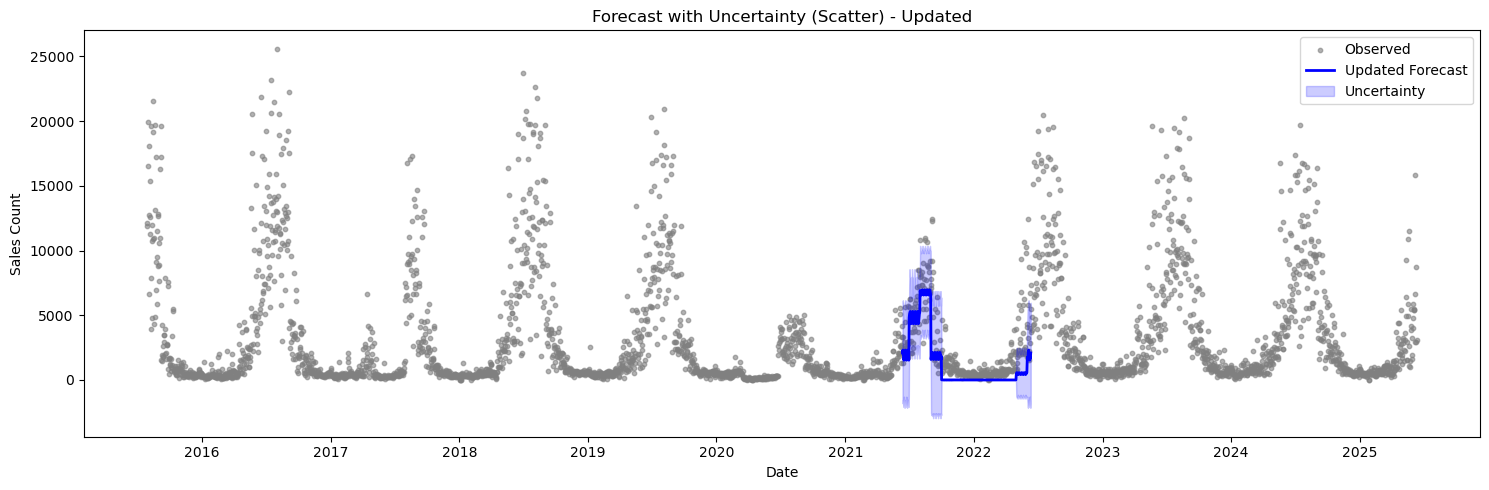

        Feature  Importance
5   roll_mean_7    0.652203
9     dayofweek    0.208981
0       monthly    0.031214
6    roll_std_7    0.027475
8   roll_std_30    0.020111
4        lag_30    0.016938
7  roll_mean_30    0.016769
3         lag_7    0.014541
2         lag_1    0.011768
1       quarter    0.000000


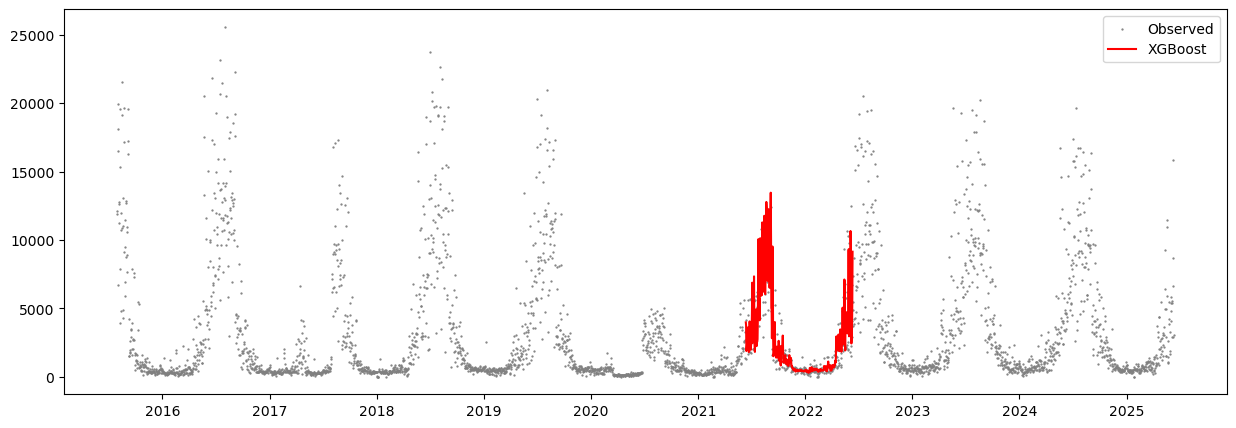

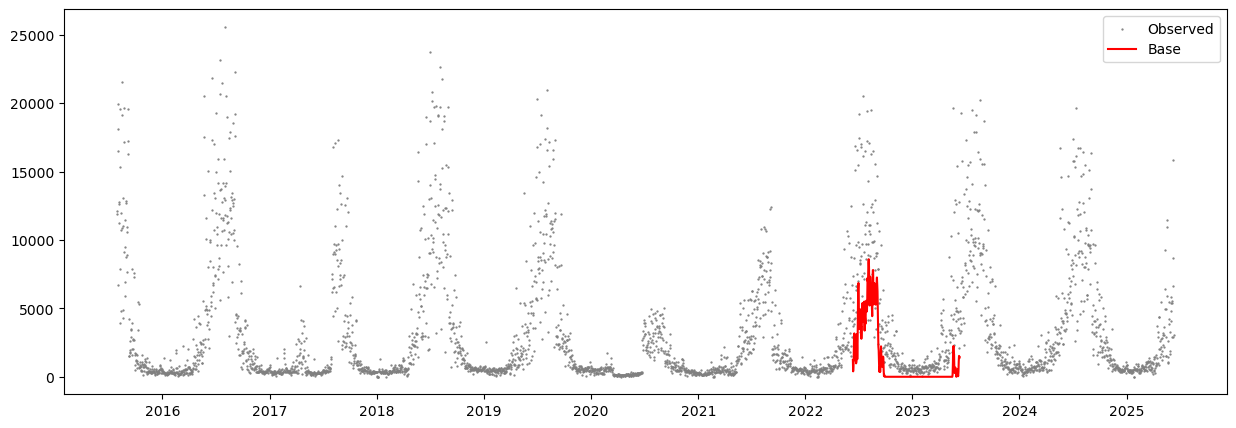

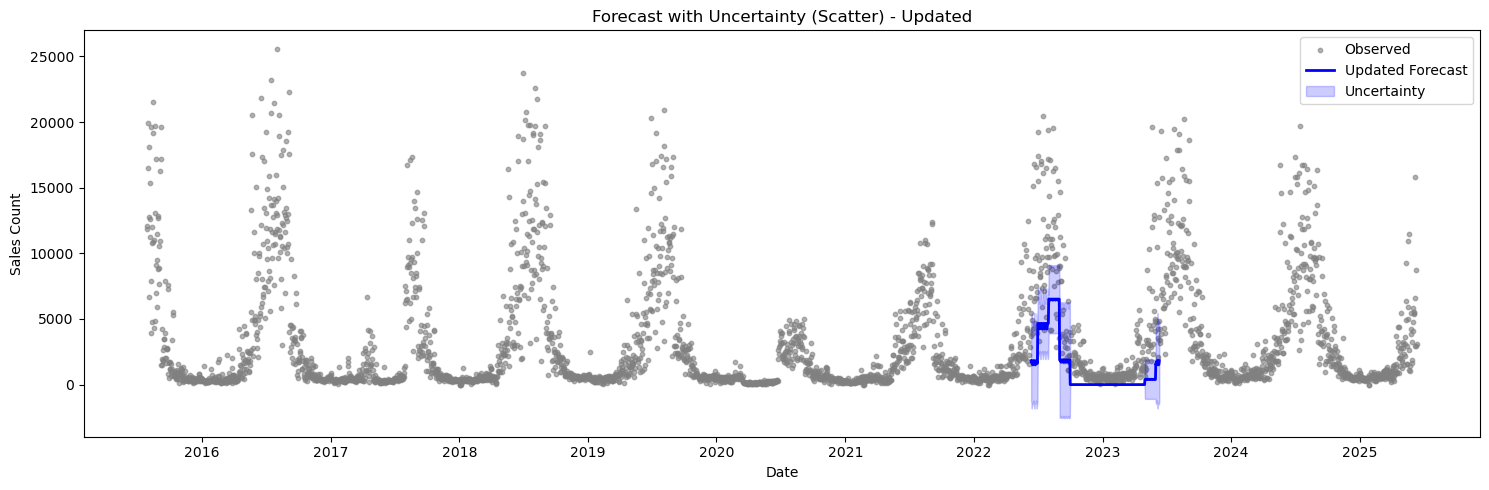

        Feature  Importance
5   roll_mean_7    0.701478
9     dayofweek    0.165352
0       monthly    0.031794
6    roll_std_7    0.026026
4        lag_30    0.016994
8   roll_std_30    0.015550
7  roll_mean_30    0.014803
3         lag_7    0.014727
2         lag_1    0.013278
1       quarter    0.000000


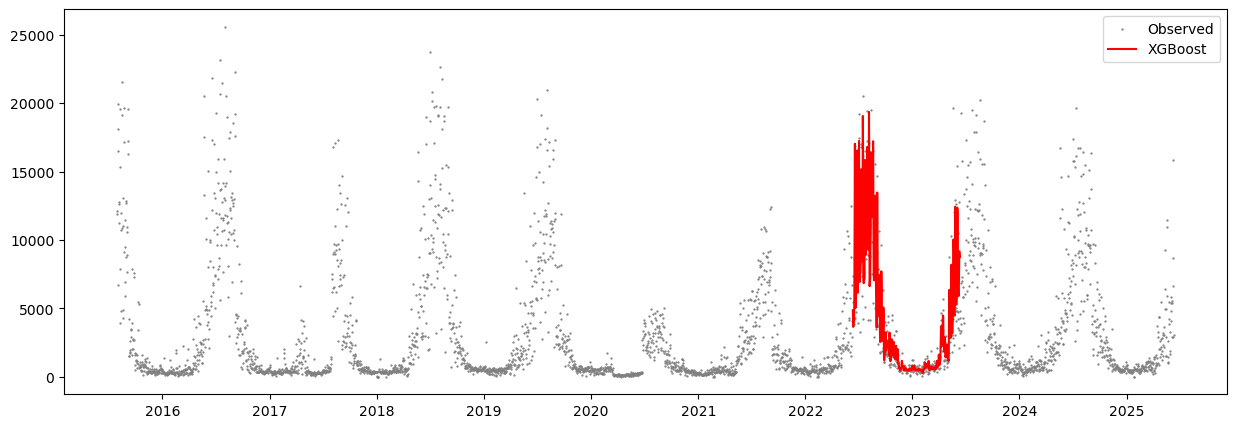

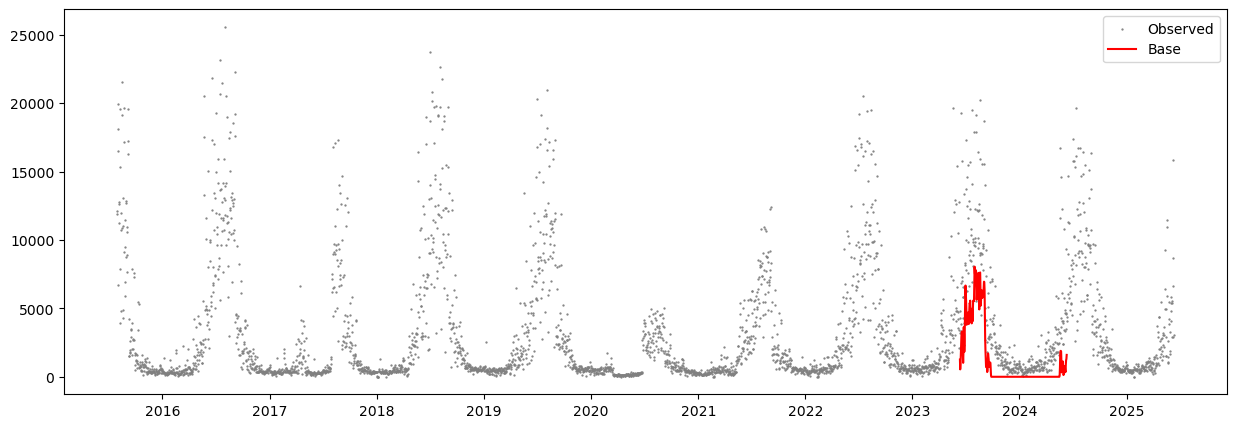

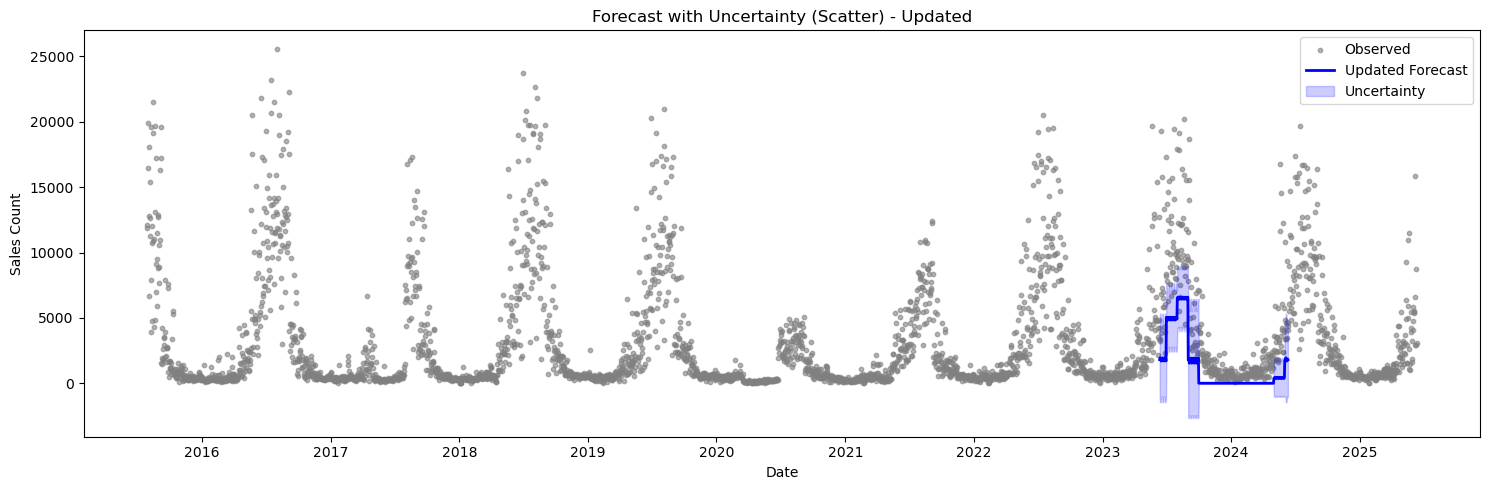

        Feature  Importance
5   roll_mean_7    0.704237
9     dayofweek    0.182322
0       monthly    0.023451
6    roll_std_7    0.022545
8   roll_std_30    0.017902
3         lag_7    0.013373
4        lag_30    0.013006
2         lag_1    0.011653
7  roll_mean_30    0.011511
1       quarter    0.000000


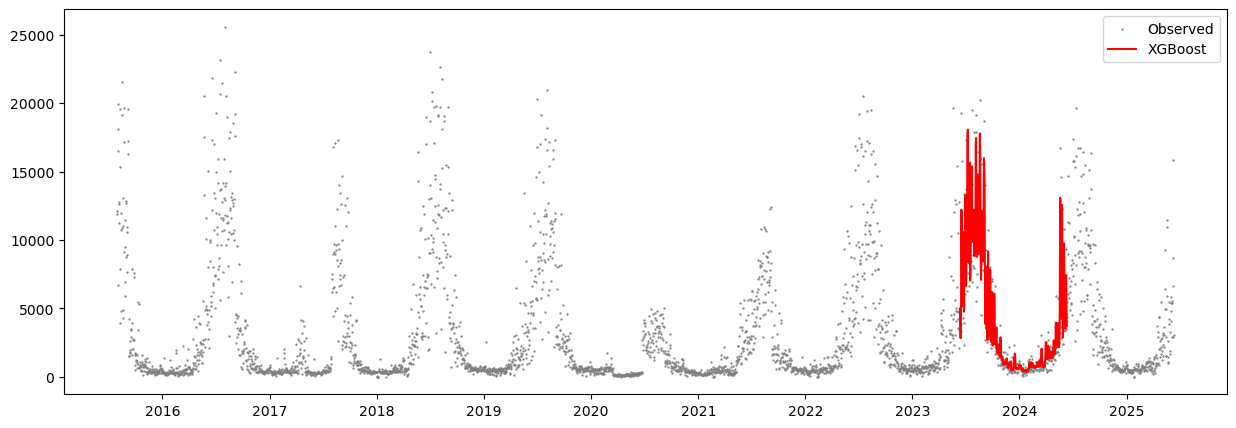

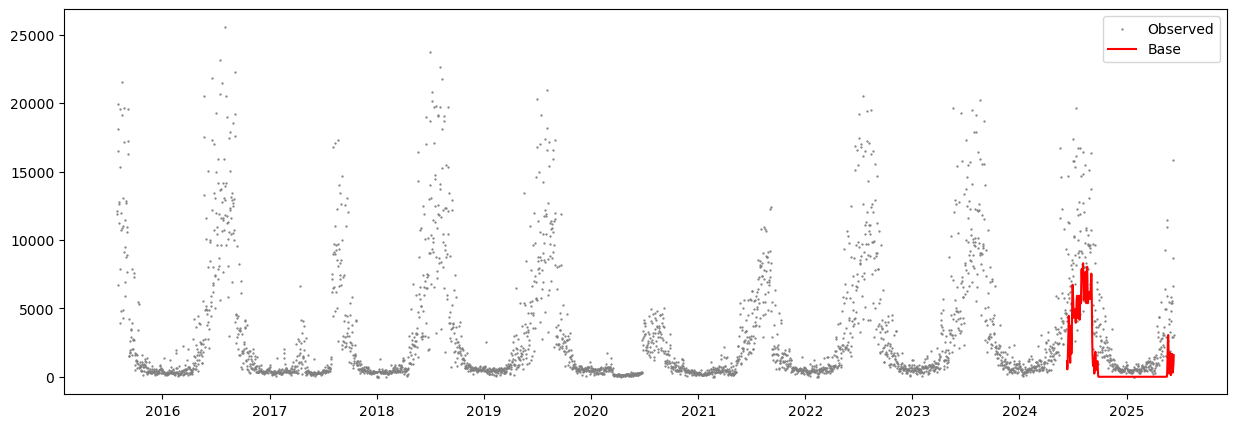

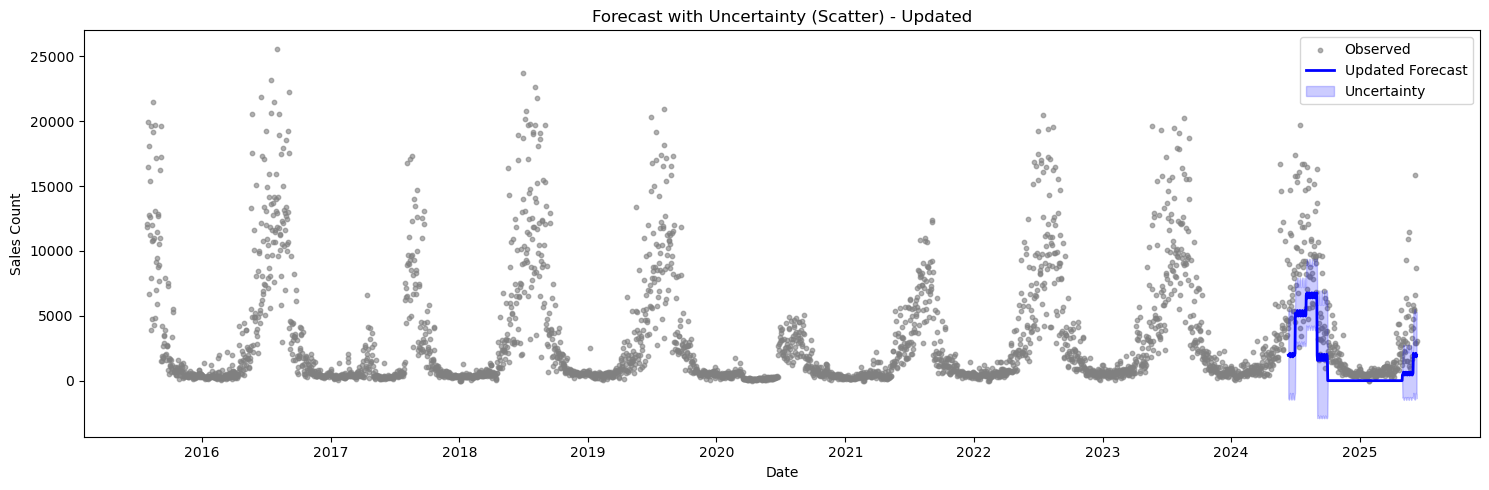

        Feature  Importance
5   roll_mean_7    0.704146
9     dayofweek    0.176364
0       monthly    0.024200
6    roll_std_7    0.023268
8   roll_std_30    0.017759
7  roll_mean_30    0.014345
2         lag_1    0.013716
3         lag_7    0.013371
4        lag_30    0.012831
1       quarter    0.000000


{'Base': {0: {'MAPE': 0.8213298088723193,
   'RMSE': 2255.095351927652,
   'MSE': 5085455.0462857},
  1: {'MAPE': 0.8543780110736318,
   'RMSE': 4248.820743635817,
   'MSE': 18052477.71155002},
  2: {'MAPE': 0.8501801175896795,
   'RMSE': 3954.3969140246113,
   'MSE': 15637254.953647368},
  3: {'MAPE': 0.8461201291380459,
   'RMSE': 3680.62642259868,
   'MSE': 13547010.862731557}},
 'Updated': {0: {'MAPE': 0.7665113565945219,
   'RMSE': 2216.533987660727,
   'MSE': 4913022.918455163},
  1: {'MAPE': 0.8363984145871398,
   'RMSE': 4365.657854203411,
   'MSE': 19058968.499967936},
  2: {'MAPE': 0.8307075383337085,
   'RMSE': 4128.303733739214,
   'MSE': 17042891.71800514},
  3: {'MAPE': 0.816778484565276,
   'RMSE': 3645.584763579167,
   'MSE': 13290288.26844057}},
 'XGBoost': {0: {'MAPE': 1.344241351552114,
   'RMSE': 1170.258132683064,
   'MSE': 1369504.097110852},
  1: {'MAPE': 0.43166828123156603,
   'RMSE': 1629.7011869270439,
   'MSE': 2655925.9586714157},
  2: {'MAPE': 0.4091999896

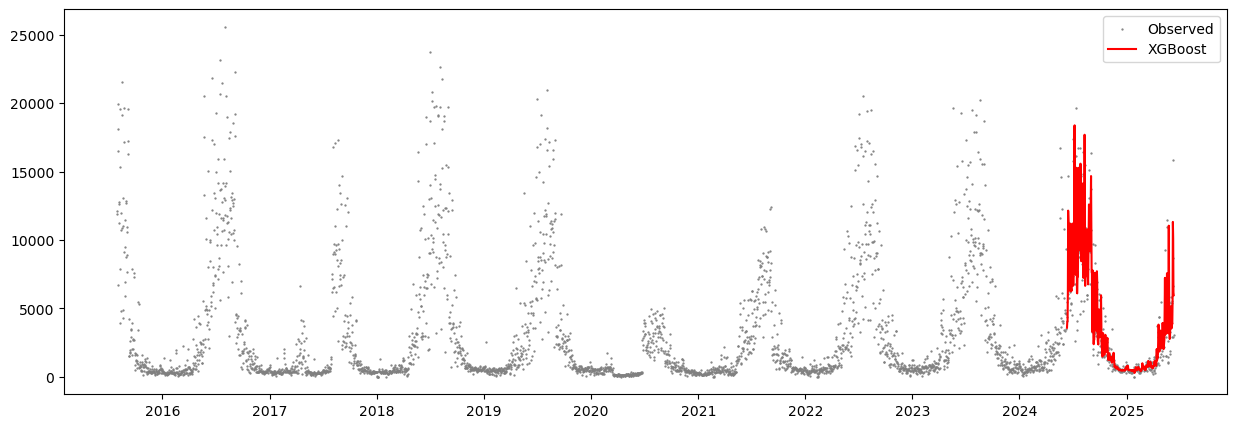

In [382]:
#we can remove redemption information and run the model again
df_noredem = df_daily.drop(columns='Redemption Count')
rm = RedemptionModel(df_noredem, 'Sales Count')
rm.run_models()
rm.results

### Run SaleModel

In [385]:
import subprocess
import sys

def install_if_missing(package):
    try:
        __import__(package)
        print(f"Package '{package}' already installed...")
    except ImportError:
        print(f"Package '{package}' not found. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_if_missing('gluonts')
install_if_missing('gluonts[torch]')
#!pip install gluonts

Package 'gluonts' already installed...
Package 'gluonts[torch]' not found. Installing...


             Feature  Importance
0   Redemption Count    0.970557
6        roll_mean_7    0.005765
10         dayofweek    0.004216
1            monthly    0.003845
9        roll_std_30    0.003204
4              lag_7    0.002947
5             lag_30    0.002793
8       roll_mean_30    0.002380
7         roll_std_7    0.002192
3              lag_1    0.002101
2            quarter    0.000000


13:35:37 - cmdstanpy - INFO - Chain [1] start processing
13:35:38 - cmdstanpy - INFO - Chain [1] done processing
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\ashan\anaconda\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | Mode  | In sizes                                                          | Out sizes    
----------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | train | [[1, 1], [1, 1], [1, 1457, 4], [1, 1457], [1, 1457], [1, 365, 4]] | [1, 100, 365]
----------------------------------------------------------------------------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 8.52324 (best 8.52324), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_5\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.67444 (best 7.67444), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_5\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.54326 (best 7.54326), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_5\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.50043 (best 7.50043), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_5\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.43527 (best 7.43527), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_5\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5

             Feature  Importance
0   Redemption Count    0.964777
6        roll_mean_7    0.008224
1            monthly    0.005276
9        roll_std_30    0.004209
10         dayofweek    0.003915
8       roll_mean_30    0.003459
5             lag_30    0.002739
4              lag_7    0.002707
7         roll_std_7    0.002434
3              lag_1    0.002259
2            quarter    0.000000


13:54:55 - cmdstanpy - INFO - Chain [1] start processing
13:54:56 - cmdstanpy - INFO - Chain [1] done processing
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\ashan\anaconda\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | Mode  | In sizes                                                          | Out sizes    
----------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | train | [[1, 1], [1, 1], [1, 1457, 4], [1, 1457], [1, 1457], [1, 365, 4]] | [1, 100, 365]
----------------------------------------------------------------------------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 8.33410 (best 8.33410), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_6\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.63892 (best 7.63892), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_6\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.55596 (best 7.55596), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_6\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.44088 (best 7.44088), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_6\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.39398 (best 7.39398), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_6\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5

             Feature  Importance
0   Redemption Count    0.968788
6        roll_mean_7    0.006337
10         dayofweek    0.004921
1            monthly    0.004404
9        roll_std_30    0.004276
8       roll_mean_30    0.002471
7         roll_std_7    0.002312
5             lag_30    0.002211
3              lag_1    0.002148
4              lag_7    0.002133
2            quarter    0.000000


14:14:07 - cmdstanpy - INFO - Chain [1] start processing
14:14:07 - cmdstanpy - INFO - Chain [1] done processing
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\ashan\anaconda\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | Mode  | In sizes                                                          | Out sizes    
----------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | train | [[1, 1], [1, 1], [1, 1457, 4], [1, 1457], [1, 1457], [1, 365, 4]] | [1, 100, 365]
----------------------------------------------------------------------------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 8.73669 (best 8.73669), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_7\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.81374 (best 7.81374), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_7\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.63252 (best 7.63252), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_7\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.52715 (best 7.52715), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_7\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.50056 (best 7.50056), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_7\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5

             Feature  Importance
0   Redemption Count    0.969473
6        roll_mean_7    0.005748
1            monthly    0.005199
10         dayofweek    0.004309
9        roll_std_30    0.003650
8       roll_mean_30    0.002943
7         roll_std_7    0.002418
4              lag_7    0.002202
5             lag_30    0.002173
3              lag_1    0.001886
2            quarter    0.000000


14:34:20 - cmdstanpy - INFO - Chain [1] start processing
14:34:21 - cmdstanpy - INFO - Chain [1] done processing
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\ashan\anaconda\Lib\site-packages\lightning\pytorch\trainer\configuration_validator.py:70: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name  | Type        | Params | Mode  | In sizes                                                          | Out sizes    
----------------------------------------------------------------------------------------------------------------------------------
0 | model | DeepARModel | 25.9 K | train | [[1, 1], [1, 1], [1, 1457, 4], [1, 1457], [1, 1457], [1, 365, 4]] | [1, 100, 365]
----------------------------------------------------------------------------------------------------------------------------------
25.9 K    Trainable params
0         Non-trainable params
25.9 K    Total params
0.

Training: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 50: 'train_loss' reached 8.66867 (best 8.66867), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_8\\checkpoints\\epoch=0-step=50.ckpt' as top 1
Epoch 1, global step 100: 'train_loss' reached 7.89226 (best 7.89226), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_8\\checkpoints\\epoch=1-step=100.ckpt' as top 1
Epoch 2, global step 150: 'train_loss' reached 7.72566 (best 7.72566), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_8\\checkpoints\\epoch=2-step=150.ckpt' as top 1
Epoch 3, global step 200: 'train_loss' reached 7.67328 (best 7.67328), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_8\\checkpoints\\epoch=3-step=200.ckpt' as top 1
Epoch 4, global step 250: 'train_loss' reached 7.59613 (best 7.59613), saving model to 'C:\\Users\\ashan\\Desktop\\govmb_test\\lightning_logs\\version_8\\checkpoints\\epoch=4-step=250.ckpt' as top 1
Epoch 5

{'Base': {0: {'MAPE': 0.8213298088723193,
   'RMSE': 2255.095351927652,
   'MSE': 5085455.0462857},
  1: {'MAPE': 0.8543780110736318,
   'RMSE': 4248.820743635817,
   'MSE': 18052477.71155002},
  2: {'MAPE': 0.8501801175896795,
   'RMSE': 3954.3969140246113,
   'MSE': 15637254.953647368},
  3: {'MAPE': 0.8461201291380459,
   'RMSE': 3680.62642259868,
   'MSE': 13547010.862731557}},
 'SARIMA': {0: {'MAPE': 10.145102007321796,
   'RMSE': 2854.1142174101333,
   'MSE': 8145967.966022657},
  1: {'MAPE': 4.718085108071331,
   'RMSE': 4665.374881780465,
   'MSE': 21765722.787548095},
  2: {'MAPE': 5.024149247497924,
   'RMSE': 5022.659706772887,
   'MSE': 25227110.530039907},
  3: {'MAPE': 8.243105819168438e+16,
   'RMSE': 4501.195606152089,
   'MSE': 20260761.88484287}},
 'XGBoost': {0: {'MAPE': 0.2429666995333317,
   'RMSE': 754.0901815030466,
   'MSE': 568652.0018392977},
  1: {'MAPE': 0.10365153312772264,
   'RMSE': 463.1655345570169,
   'MSE': 214522.3124014872},
  2: {'MAPE': 0.09596339

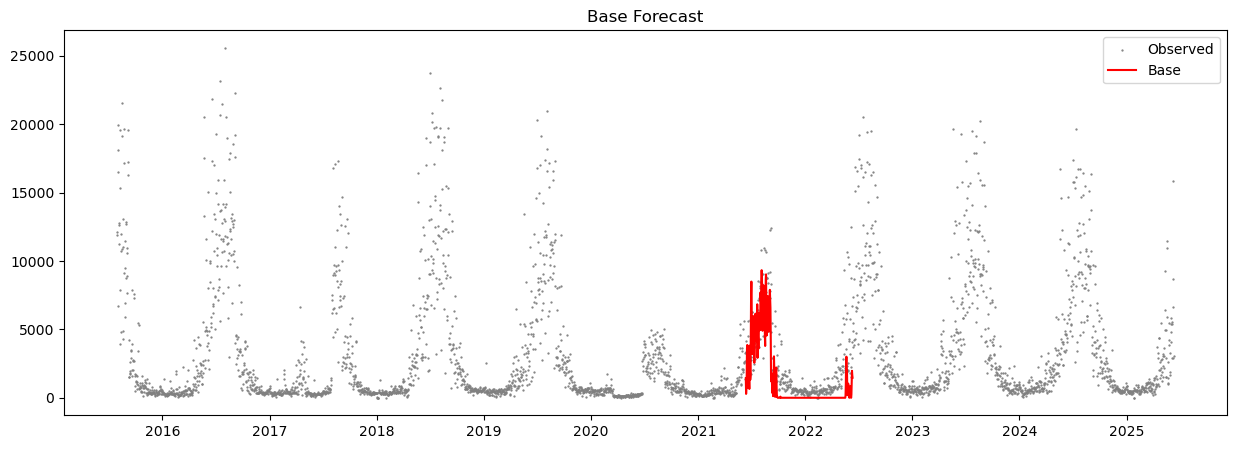

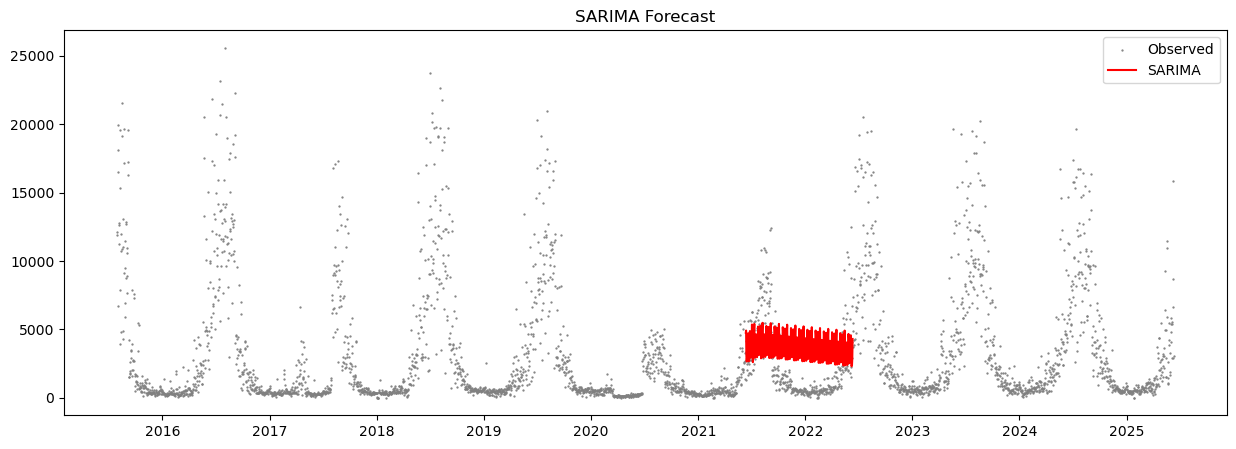

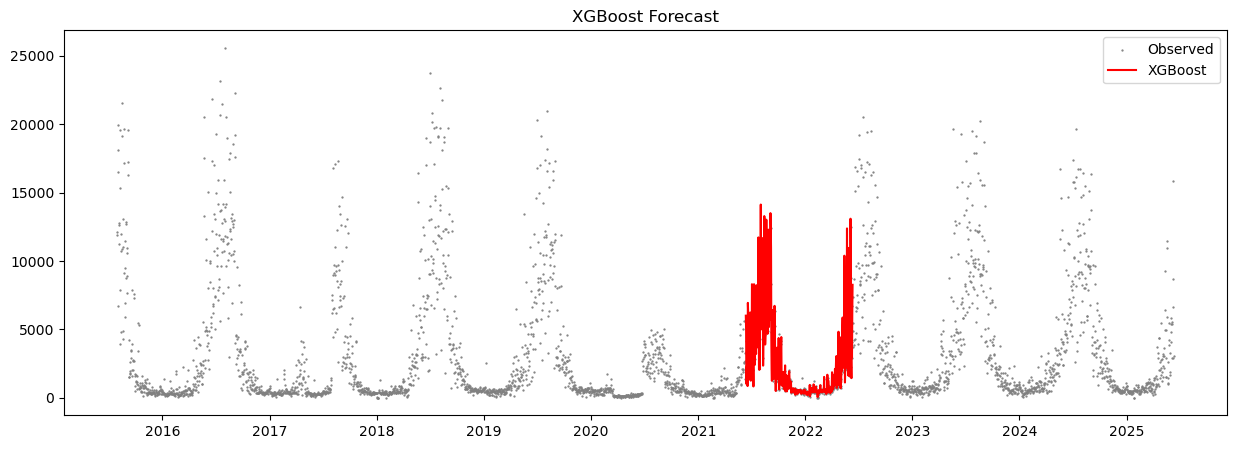

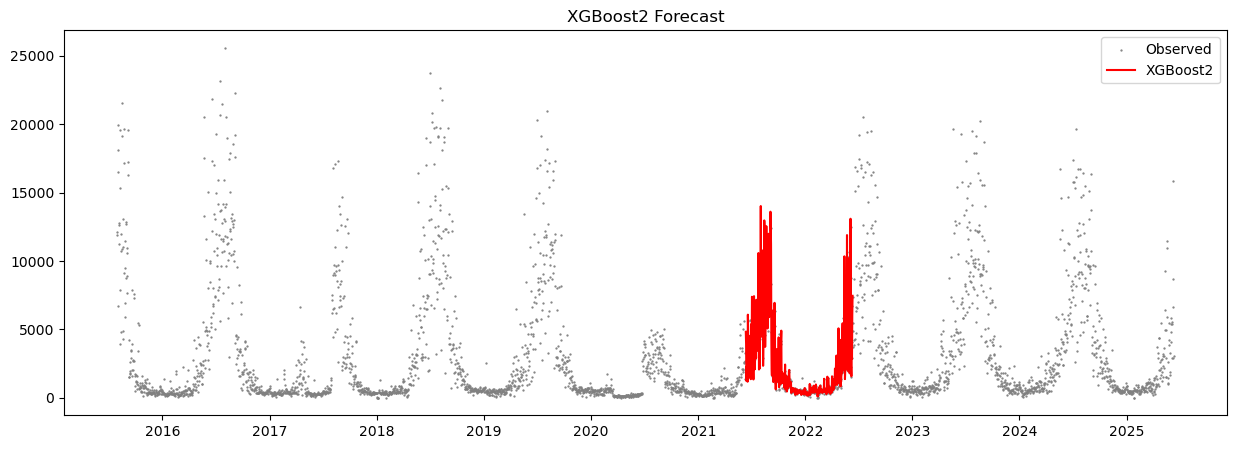

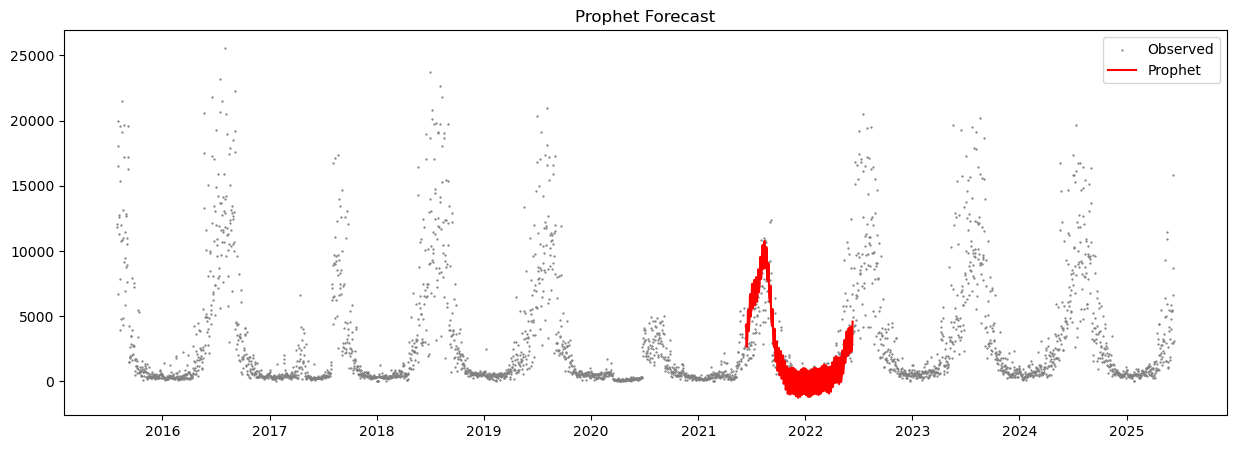

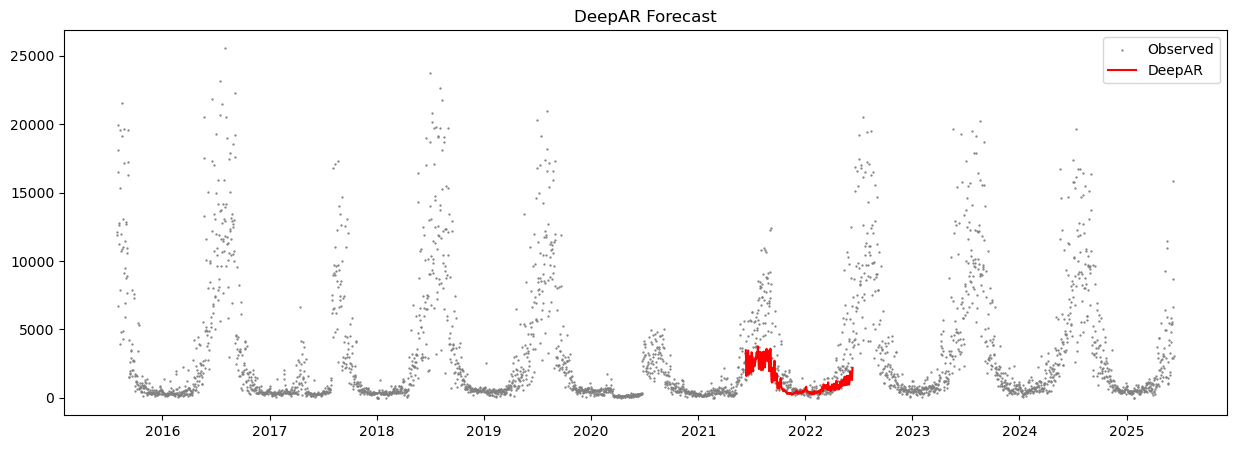

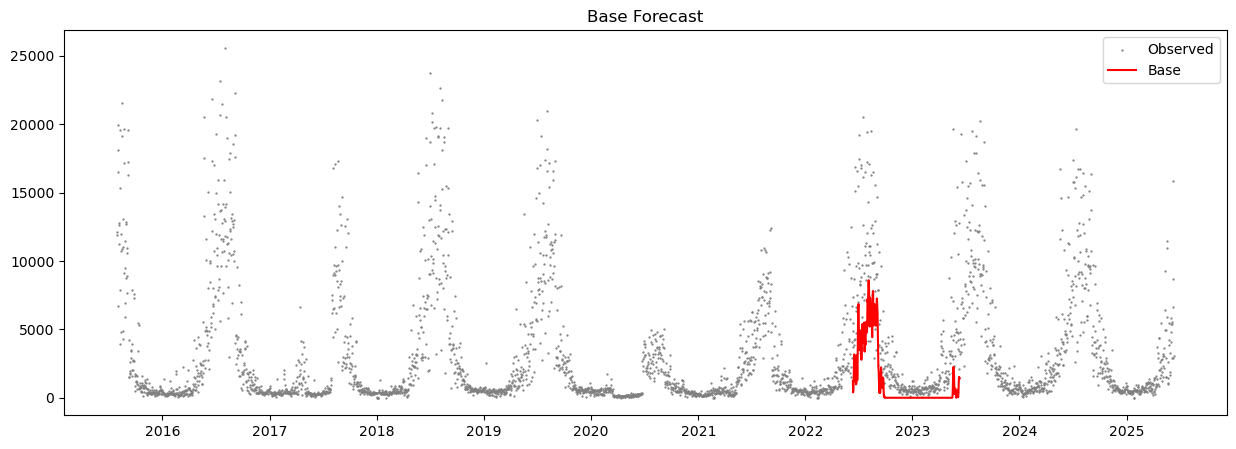

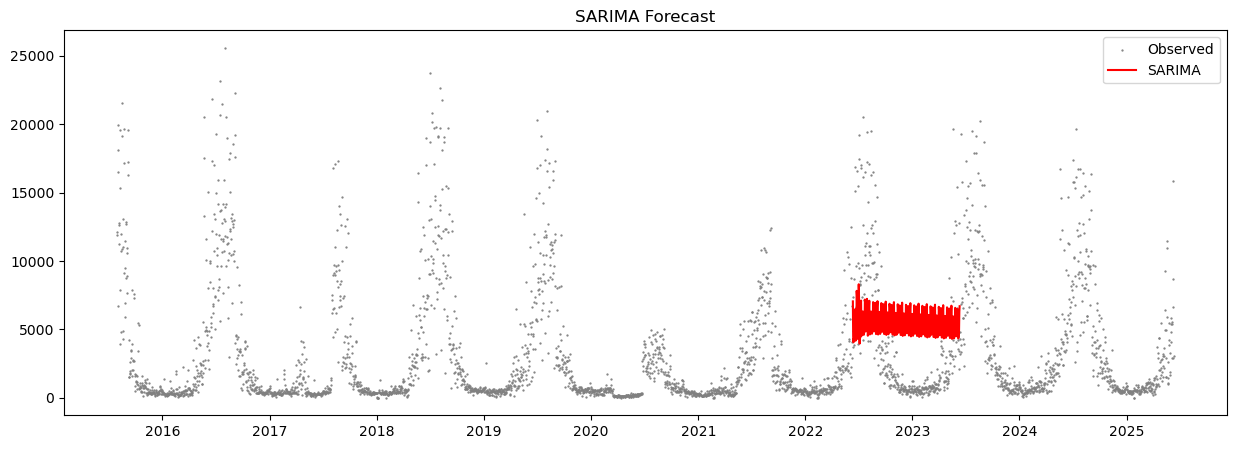

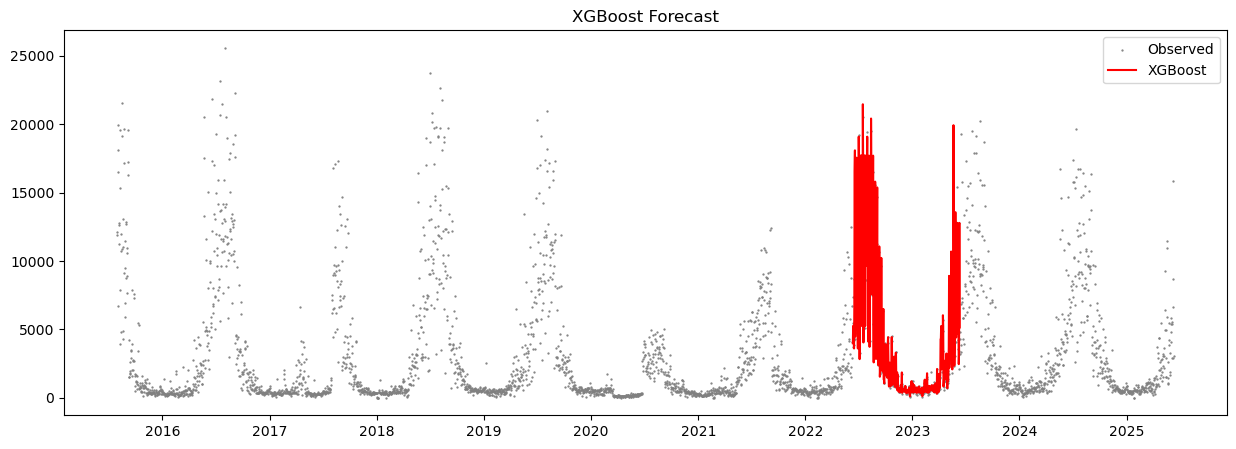

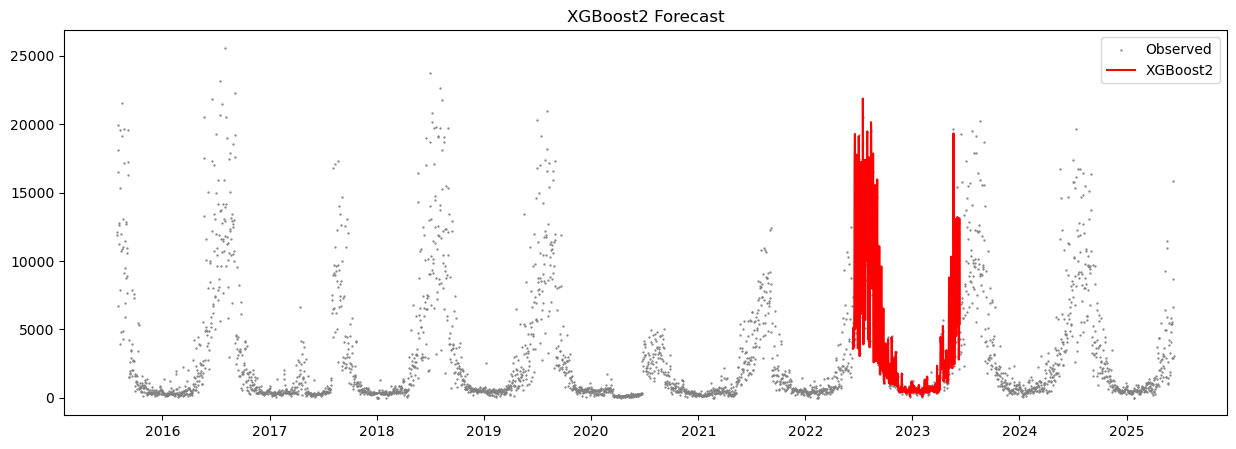

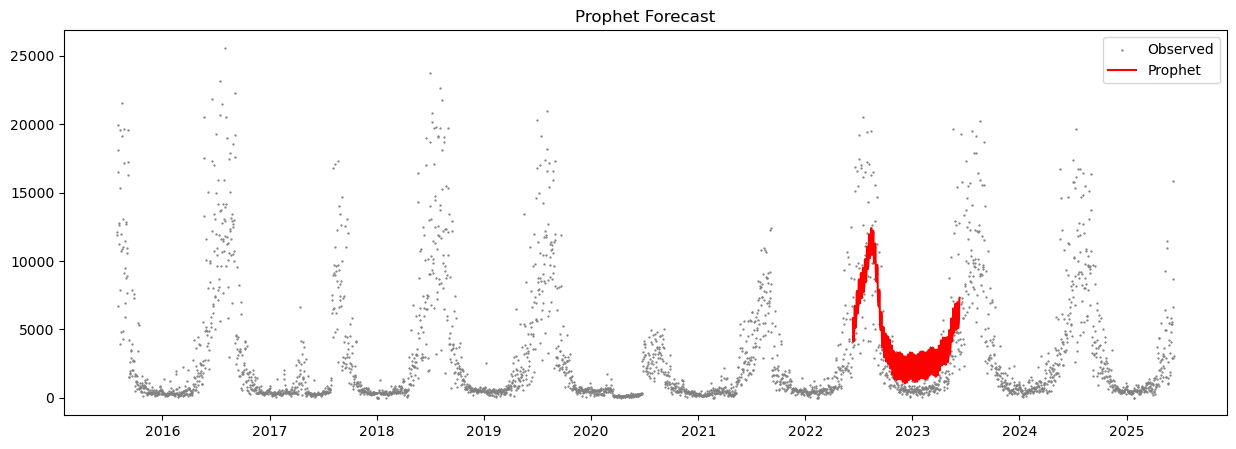

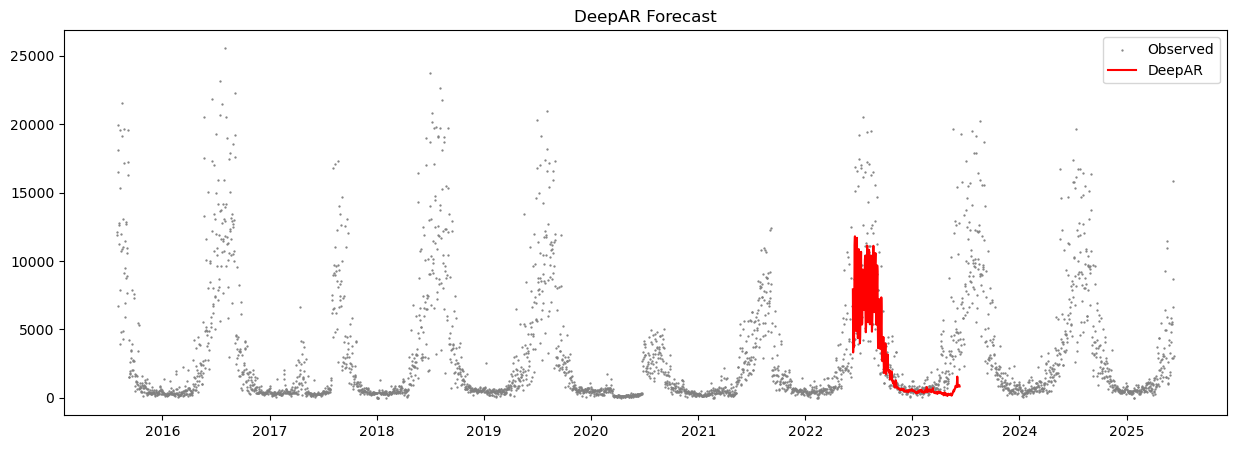

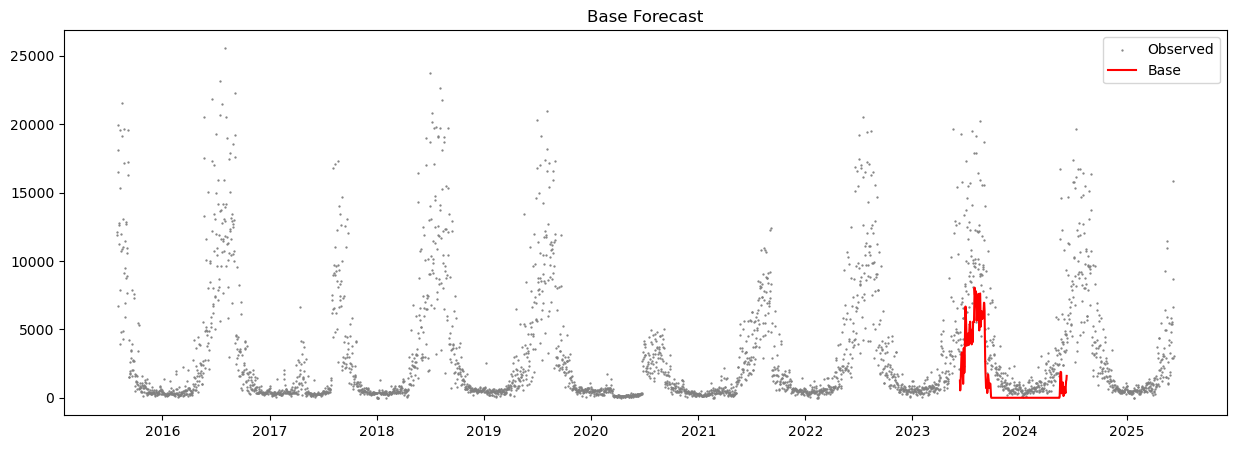

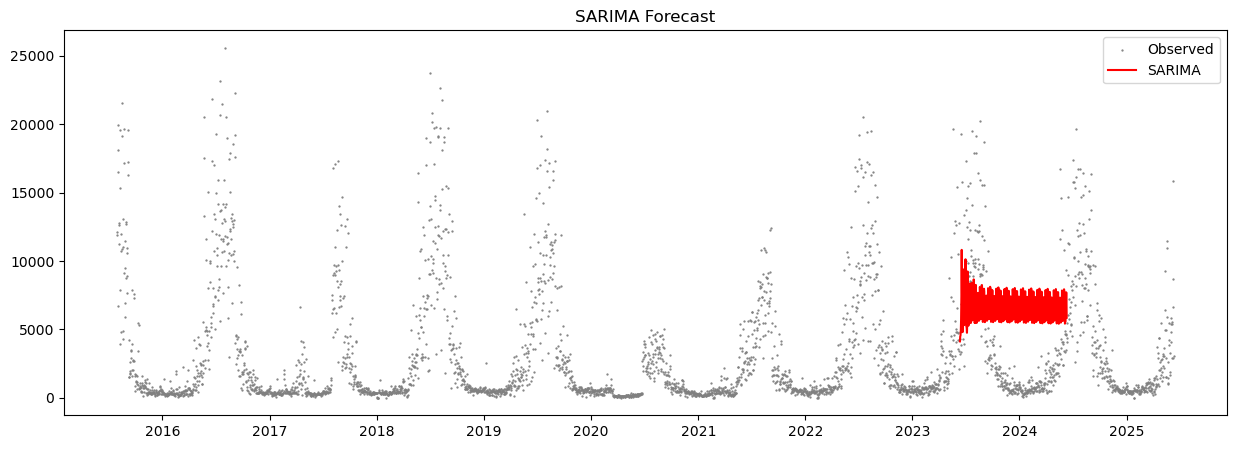

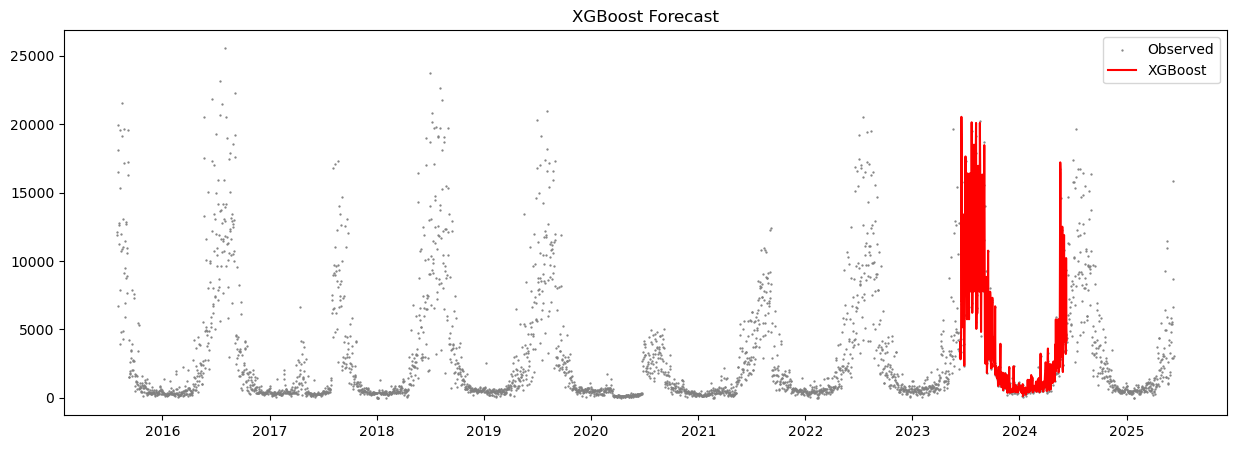

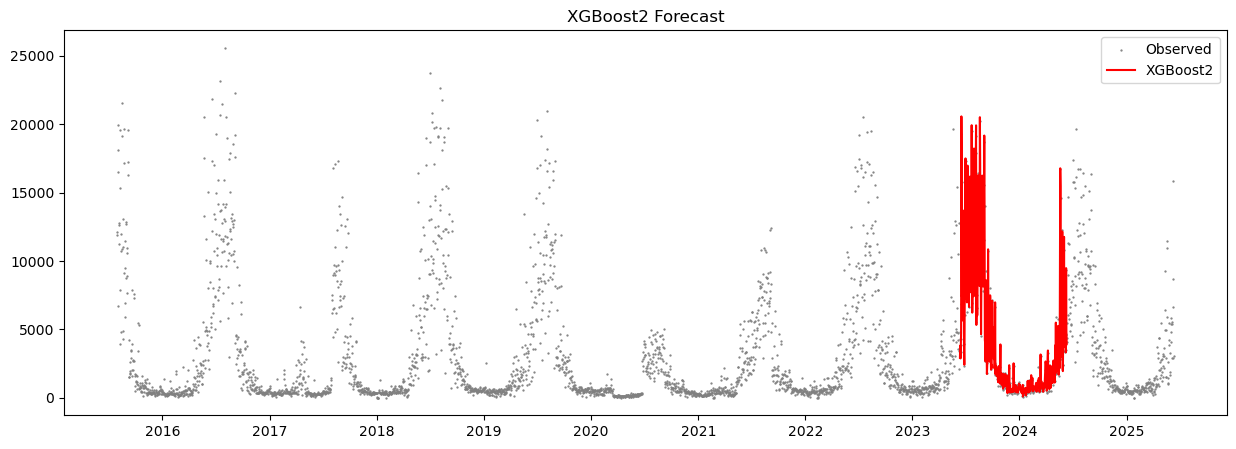

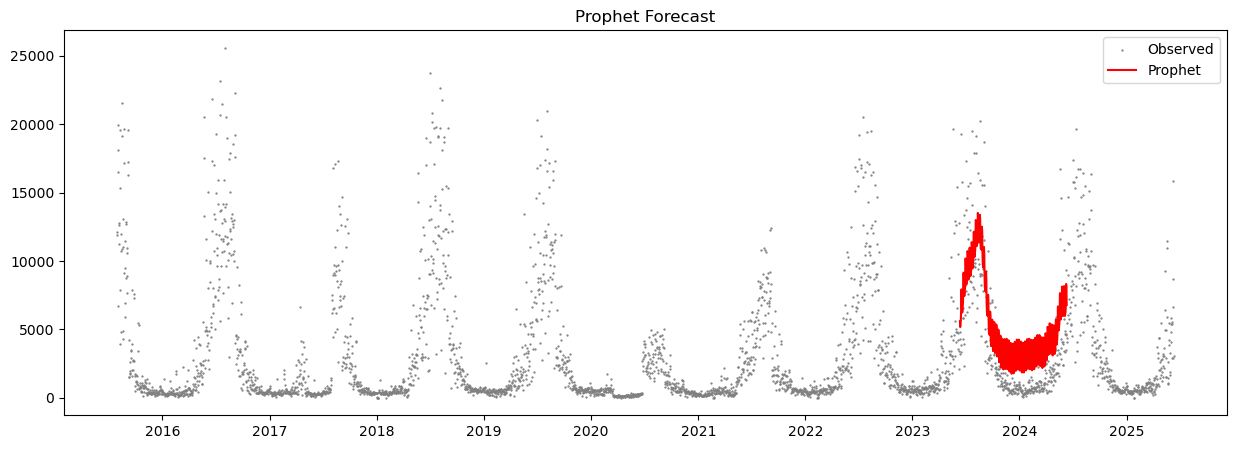

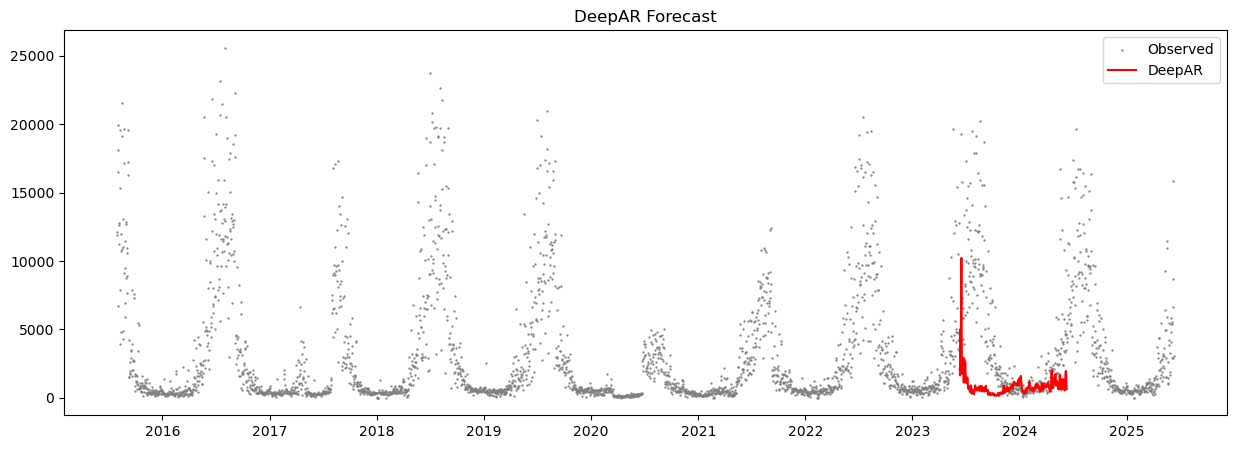

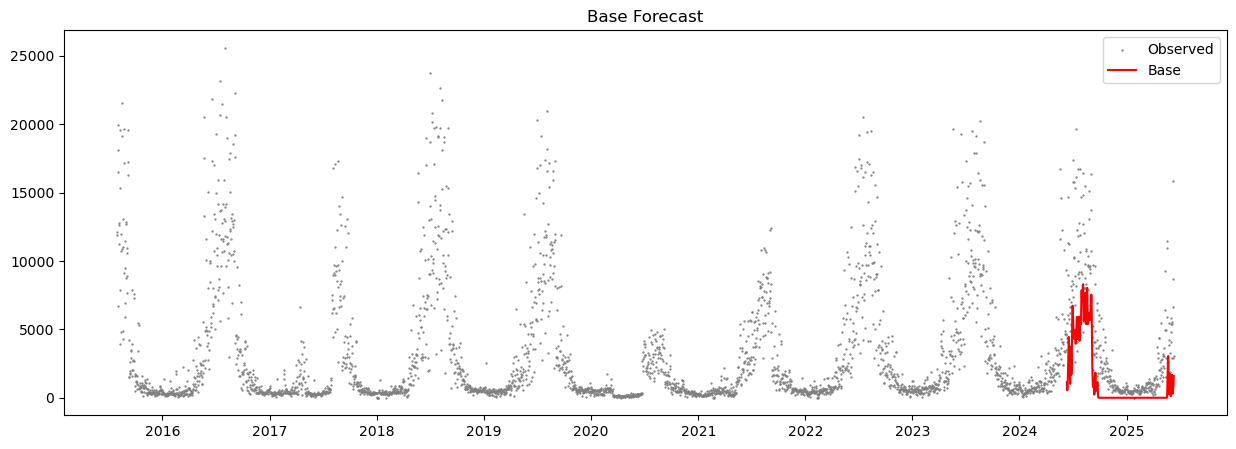

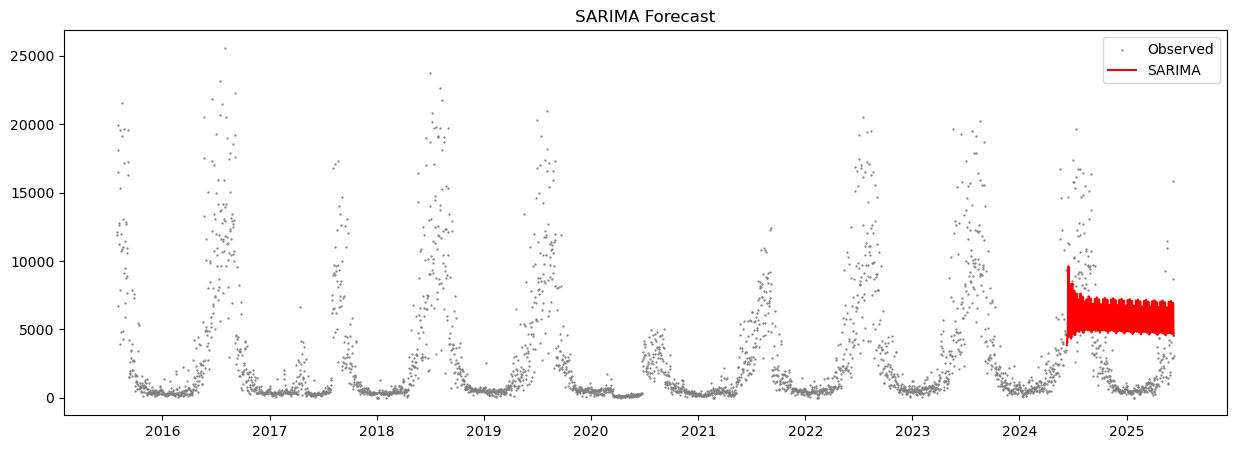

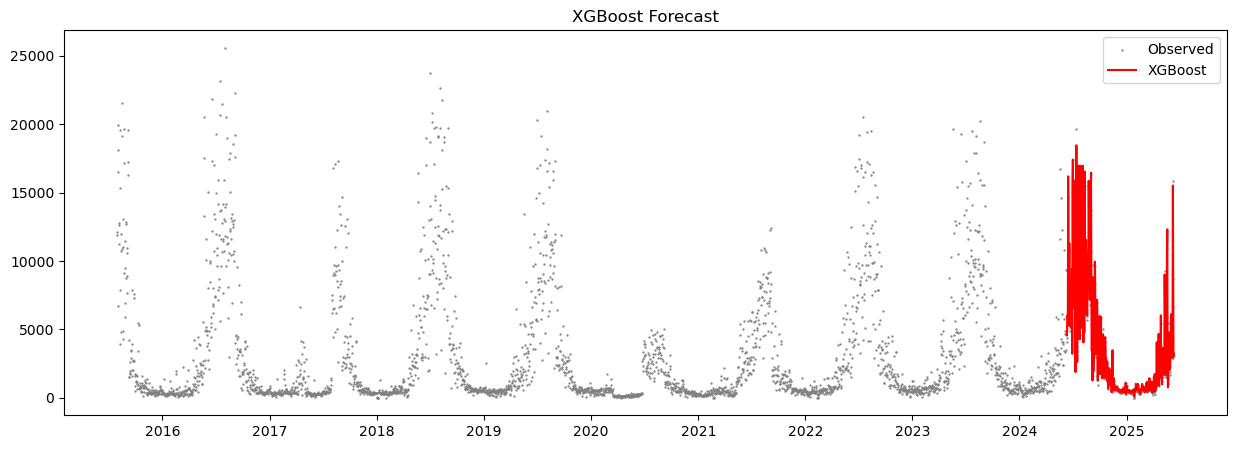

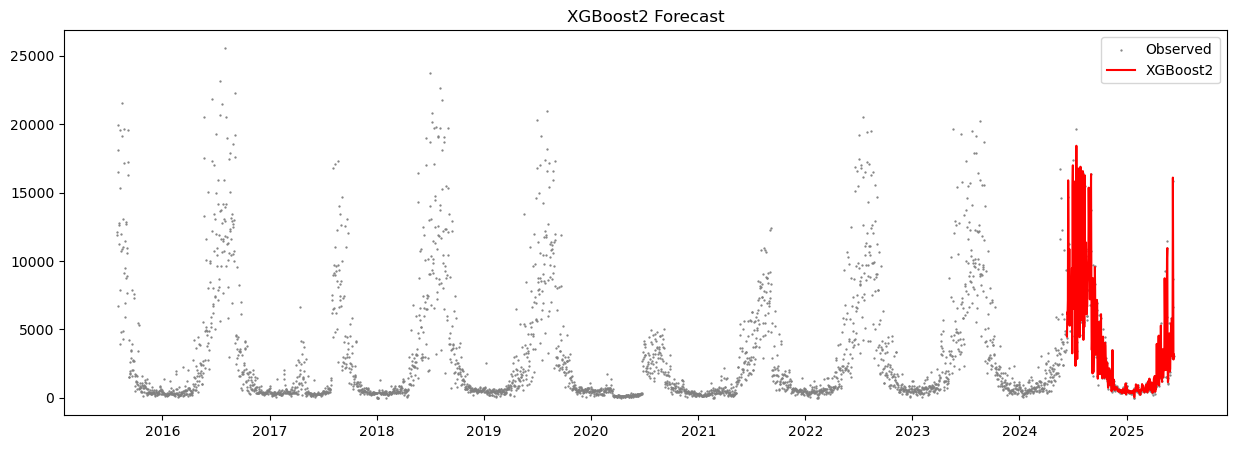

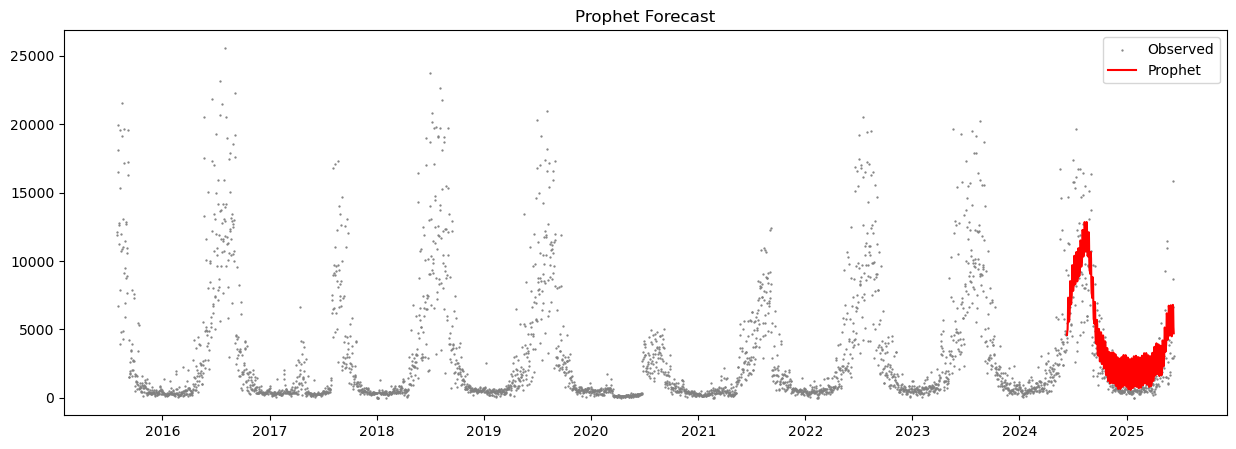

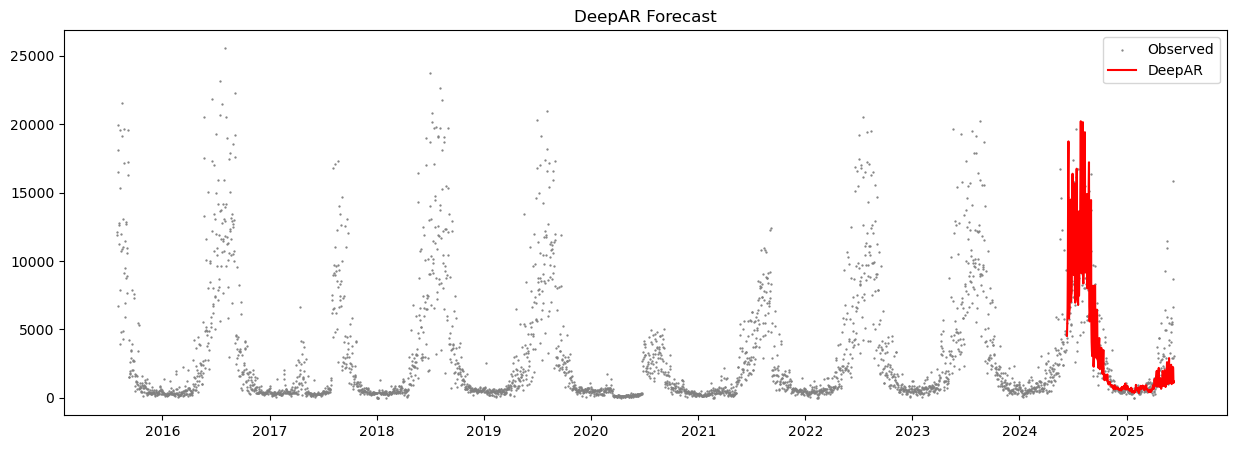

In [390]:
rm=SalesModel(df_daily, 'Sales Count')
rm.run_models()
rm.results